In [1]:
# additional packages

import numpy as np
from pandas import read_csv
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import geopandas as gpd
import contextily as cx
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import visualkit_delta as vkd
import warnings
warnings.filterwarnings('ignore')

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

In [2]:
# define scenario
scenario_name = 'Seattle'
analysis_years = ['2018', '2050']
input_dir = 'inputs_' + scenario_name
plot_dir = 'plots_Seattle_2050'

lehd_file = 'US_naics.csv'
map_file = scenario_name + '_freight.geojson'

us_ton_to_ton = 0.907185
miles_to_km = 1.60934

CFS_to_FAF_mapping = {'For-hire Truck':'Truck', 
                      'Private Truck': 'Truck', 
                      'Rail/IMX': 'Rail and IMX', 
                      'Air':'Air and Parcel', 
                      'Parcel':'Air and Parcel'}

FAF_mode_lookup = {1: 'Truck', 2: 'Rail and IMX', 3: 'Other', 4: 'Air and Parcel', 
               5: 'Air and Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}

commodity_label = {'bulk': 'Bulk', 'fuel_fert': 'Fuel, fertilizer and chemicals',
                  'interm_food': 'Food and interim product', 'mfr_goods': 'Manufactured goods',
                  'other':'Other'}

# 1 - Input loading

In [4]:
# load FAF data
# mapping FAF mode to SynthFirm mode

region_code = [411, 531, 532, 539]
focus_region = 531
faf_data = read_csv('Validation/' + 'FAF5.6.1.csv', sep = ',')
#load parameters
sctg_group_lookup = read_csv('SynthFirm_parameters/' + 'SCTG_Groups_revised.csv', sep = ',')
cfs_faf_lookup = read_csv('SynthFirm_parameters/' + 'CFS_FAF_LOOKUP.csv', sep = ',')

sctg_names = sctg_group_lookup['SCTG_Name'].unique()
sctg_group_definition = sctg_group_lookup.loc[:, ['SCTG_Group', 'SCTG_Name']]
sctg_group_definition = sctg_group_definition.drop_duplicates()

faf_data.loc[:, 'Mode'] = faf_data.loc[:, 'dms_mode'].map(FAF_mode_lookup)
faf_data = pd.merge(faf_data, sctg_group_lookup, left_on = 'sctg2', right_on = 'SCTG_Code', how = 'left')

trade_type_id = 1 # domestic only
faf_data_domestic = faf_data.loc[faf_data['trade_type'] == trade_type_id]

faf_data_domestic = \
faf_data_domestic.loc[faf_data_domestic['Mode'] != 'Other']
faf_data_domestic.head(5)

if focus_region is not None: # regional
    faf_outflow = faf_data_domestic.loc[faf_data_domestic['dms_orig'] == focus_region]
    faf_inflow = faf_data_domestic.loc[faf_data_domestic['dms_dest'] == focus_region]

else: # national
    faf_outflow = faf_data_domestic.copy()
    faf_inflow = faf_data_domestic.copy()


In [5]:
# load SynthFirm outputs

mesozone_id_lookup = read_csv(os.path.join(input_dir, 'zonal_id_lookup_final.csv'))

output_dir_base = 'outputs_' + scenario_name
output_dir_2050 = 'outputs_' + scenario_name + '_2050'

synthfirm_output_base = read_csv(os.path.join(output_dir_base, 'processed_b2b_flow_summary_mesozone.csv'))
synthfirm_output_base.loc[:, 'Mode'] = synthfirm_output_base.loc[:, 'mode_choice'].map(CFS_to_FAF_mapping)
synthfirm_output_base.dropna(subset = ['Mode'], inplace = True)
synthfirm_outflow_base = synthfirm_output_base.loc[synthfirm_output_base['orig_FAFID'] == focus_region]
synthfirm_inflow_base = synthfirm_output_base.loc[synthfirm_output_base['dest_FAFID'] == focus_region]
print(len(synthfirm_output_base))

synthfirm_output_2050 = read_csv(os.path.join(output_dir_2050, 'processed_b2b_flow_summary_mesozone.csv'))
synthfirm_output_2050.loc[:, 'Mode'] = synthfirm_output_2050.loc[:, 'mode_choice'].map(CFS_to_FAF_mapping)
synthfirm_output_2050.dropna(subset = ['Mode'], inplace = True)
synthfirm_outflow_2050 = synthfirm_output_2050.loc[synthfirm_output_2050['orig_FAFID'] == focus_region]
synthfirm_inflow_2050 = synthfirm_output_2050.loc[synthfirm_output_2050['dest_FAFID'] == focus_region]
print(len(synthfirm_output_2050))

synthfirm_output_base.head(5)

671400
707135


Unnamed: 0  SellerZone  orig_FAFID orig_FAFNAME     BuyerZone  dest_FAFID  \
0           0     20001.0        11.0   Birmingham  5.304197e+11       531.0   
1           1     20001.0        11.0   Birmingham  5.304197e+11       531.0   
2           2     20001.0        11.0   Birmingham  5.304197e+11       531.0   
3           3     20003.0        19.0   Rest of AL  5.303301e+11       531.0   
4           4     20003.0        19.0   Rest of AL  5.303301e+11       531.0   

  dest_FAFNAME  Commodity_SCTG  SCTG_Group  SCTG_Name     mode_choice  \
0      Seattle            39.0         4.0  mfr_goods             Air   
1      Seattle            39.0         4.0  mfr_goods  For-hire Truck   
2      Seattle            39.0         4.0  mfr_goods        Rail/IMX   
3      Seattle            39.0         4.0  mfr_goods             Air   
4      Seattle            39.0         4.0  mfr_goods  For-hire Truck   

         tmiles  ShipmentLoad  count  outbound  inbound      Distance  \
0  1.636301e+04      0.007882     10         0        1   2076.068596   
1  3.391468e+06      1.141274   1448         0        1   2971.650000   
2  8.973564e+04      0.033103     42         0        1   2710.779209   
3  4.970367e+04      0.023640     30         0        1   4231.582551   
4  7.173161e+06      2.393902   3038         0        1  51571.513512   

             Mode  
0  Air and Parcel  
1           Truck  
2    Rail and IMX  
3  Air and Parcel  
4           Truck

In [6]:
print(synthfirm_outflow_base['ShipmentLoad'].sum())
print(synthfirm_inflow_base['ShipmentLoad'].sum())
print(synthfirm_outflow_2050['ShipmentLoad'].sum())
print(synthfirm_inflow_2050['ShipmentLoad'].sum())


131285.99988663182
156569.11183249997
230411.4525804789
226992.4527438271


In [ ]:
# generate attributes needed by all sectors
param_dir = 'SynthFirm_parameters'
us_counties = gpd.read_file(os.path.join(param_dir, 'US_countries.geojson'))
# geoid +  land area
us_counties.loc[:, 'area'] = (us_counties.loc[:, 'ALAND'] + us_counties.loc[:, 'AWATER'])/ 1000000 # in km^2
us_counties.loc[:, 'GEOID'] = us_counties.loc[:, 'GEOID'].astype(np.int64).astype(str).str.zfill(5)

us_county_df = pd.DataFrame(us_counties.drop(columns = 'geometry'))

us_county_short_df = us_county_df[['GEOID', 'area']]

# spatial crosswalk
mesozone_to_county = mesozone_id_lookup[['MESOZONE', 'CBPZONE', 'FAFID',  'FAFNAME']]
mesozone_to_county.loc[:, 'MESOZONE'] = mesozone_to_county.loc[:, 'MESOZONE'].astype(np.int64)

In [7]:
# define scenario naming system

scenario_prefix = {output_dir_base: 'base_2017',
                  output_dir_2050: 'forecast_2050'}

year_mapping = {'2017': '2017',
                '2050': '2050'}


In [11]:
# pre-process region map
region_map = gpd.read_file(os.path.join(input_dir, map_file))
region_map.dropna(subset = ['geometry'], inplace = True)
# calculate land area
region_map.loc[:, "area"] = \
region_map['geometry'].to_crs({'proj':'cea'}).map(lambda p: p.area / 10**6) 

agg_level = 'MESOZONE'
# plot firm and employment results by CBG zone

region_map.loc[:, 'MESOZONE'] = \
region_map.loc[:, 'MESOZONE'].astype(np.int64).astype(str).str.zfill(12)
region_map['FAFID'] = region_map['FAFID'].astype(int)

if focus_region is not None: # regional
    region_map = region_map.loc[region_map['FAFID'] == focus_region]
region_map_df = pd.DataFrame(region_map.drop(columns=['geometry']))
print(len(region_map_df))

3046


# 2 - Data processing and aggregation

## 2.1  SynthFirm data processing

In [15]:
# Data aggregation function

def gen_comm_by_zone(synthfirm_output, region_map_df, 
                       zonal_id, col_attr, 
                       output_var, output_prefix):

    group_var = [zonal_id, col_attr]
    tonnage_in_region = synthfirm_output.groupby(group_var)[[output_var]].sum()
    tonnage_in_region = tonnage_in_region.reset_index()
    tonnage_in_region = tonnage_in_region.rename(columns = {zonal_id: 'MESOZONE'})
    tonnage_in_region['MESOZONE'] = \
    tonnage_in_region['MESOZONE'].astype(np.int64).astype(str).str.zfill(12)


    col_groups = synthfirm_output[col_attr].unique().tolist()
    col_groups.append('total')
    #print(col_groups)
    
    tonnage_by_zone = pd.pivot_table(tonnage_in_region, 
                                     index = ['MESOZONE'],
                                      columns = col_attr, values = output_var, aggfunc = 'sum')
    tonnage_by_zone.loc[:, 'total'] = tonnage_by_zone.sum(axis = 1)   
    tonnage_by_zone = tonnage_by_zone.reset_index()

    
    tonnage_by_zone = \
    pd.merge(region_map_df, tonnage_by_zone, on='MESOZONE', how='left')
    tonnage_by_zone.fillna(0, inplace = True)
    for attr in col_groups:
        attr_out = output_prefix + '_' + attr + '_per_area'
        tonnage_by_zone.loc[:,attr_out] = \
        tonnage_by_zone.loc[:, attr] * us_ton_to_ton/ \
        tonnage_by_zone.loc[:, 'area']
    tonnage_by_zone.drop(columns = col_groups, inplace = True)
    return(tonnage_by_zone)      
                           

In [16]:
# production by SCTG
production_by_sctg_base = \
                            gen_comm_by_zone(synthfirm_outflow_base, region_map_df, 
                                               'SellerZone', 'SCTG_Name', 
                                               'ShipmentLoad', '2017_prod')

production_by_sctg_2050 = \
                            gen_comm_by_zone(synthfirm_outflow_2050, region_map_df, 
                                               'SellerZone', 'SCTG_Name', 
                                               'ShipmentLoad', '2050_prod')  
production_by_sctg_base.head(5)

GEOID  FAFID      MESOZONE  CBPZONE      area  \
0  530330293053    531  530330293053    53033  0.891907   
1  530330205002    531  530330205002    53033  0.435127   
2  530530620003    531  530530620003    53053  0.291051   
3  530530613002    531  530530613002    53053  0.254453   
4  530610527055    531  530610527055    53061  0.595708   

   2017_prod_mfr_goods_per_area  2017_prod_interm_food_per_area  \
0                           0.0                             0.0   
1                           0.0                             0.0   
2                           0.0                             0.0   
3                           0.0                             0.0   
4                           0.0                             0.0   

   2017_prod_bulk_per_area  2017_prod_fuel_fert_per_area  \
0                      0.0                           0.0   
1                      0.0                           0.0   
2                      0.0                           0.0   
3                      0.0                           0.0   
4                      0.0                           0.0   

   2017_prod_other_per_area  2017_prod_total_per_area  
0                       0.0                       0.0  
1                       0.0                       0.0  
2                       0.0                       0.0  
3                       0.0                       0.0  
4                       0.0                       0.0

In [17]:
# production by mode
production_by_mode_base = \
                            gen_comm_by_zone(synthfirm_outflow_base, region_map_df, 
                                               'SellerZone', 'Mode', 
                                               'ShipmentLoad', '2017_prod')

production_by_mode_2050 = \
                            gen_comm_by_zone(synthfirm_outflow_2050, region_map_df, 
                                                'SellerZone', 'Mode', 
                                               'ShipmentLoad', '2050_prod')  

In [18]:
# consumption by SCTG
consumption_by_sctg_base = \
                            gen_comm_by_zone(synthfirm_inflow_base, region_map_df, 
                                                'BuyerZone', 'SCTG_Name',
                                               'ShipmentLoad', '2017_cons')
consumption_by_sctg_2050 = \
                            gen_comm_by_zone(synthfirm_inflow_2050, region_map_df, 
                                                'BuyerZone', 'SCTG_Name', 
                                               'ShipmentLoad', '2050_cons')  


In [19]:
# consumption by mode
consumption_by_mode_base = \
                            gen_comm_by_zone(synthfirm_inflow_base, region_map_df, 
                                               'BuyerZone', 'Mode', 
                                               'ShipmentLoad',  '2017_cons')
consumption_by_mode_2050 = \
                            gen_comm_by_zone(synthfirm_inflow_2050, region_map_df, 
                                               'BuyerZone', 'Mode', 
                                               'ShipmentLoad', '2050_cons')  


In [15]:
def gen_comm_summary(synthfirm_output, group_var, output_attr, output_name, year_id, scenario, add_total = True):

    summary_by_sector = synthfirm_output.groupby(group_var)[[output_attr]].sum()
    if output_name == 'Load':
        summary_by_sector.loc[:,output_attr] = \
        summary_by_sector.loc[:, output_attr] * us_ton_to_ton
    if output_name == 'Ton-km':
        summary_by_sector.loc[:,output_attr] = \
        summary_by_sector.loc[:, output_attr] * us_ton_to_ton * miles_to_km
    if add_total:
        summary_by_sector.loc['total'] = summary_by_sector.sum()
    summary_by_sector = summary_by_sector.reset_index()
    summary_by_sector.loc[:, 'Scenario'] = f'{scenario} ({year_id})'
    summary_by_sector.rename(columns = {output_attr: output_name}, inplace = True)
    summary_by_sector[output_name] *=us_ton_to_ton # convert to metric tons
    
    return(summary_by_sector) 

# tonnage production by SCTG
model_base_prod_by_sctg = gen_comm_summary(synthfirm_outflow_base, 
                                      ['SCTG_Name'], 'ShipmentLoad', 
                                      'Load', '2017',  'Baseline')

model_2050_prod_by_sctg = gen_comm_summary(synthfirm_outflow_2050, 
                                      ['SCTG_Name'], 'ShipmentLoad', 
                                      'Load', '2050', 'Forecast')


modeled_prod_by_sctg = pd.concat([model_base_prod_by_sctg, 
                                     model_2050_prod_by_sctg])
modeled_prod_by_sctg.loc[:, 'Source'] = 'SynthFirm'

# tonnage production by mode
model_base_prod_by_mode = gen_comm_summary(synthfirm_outflow_base, 
                                      ['Mode'], 'ShipmentLoad', 'Load', '2017',  'Baseline',
                                     add_total = False)

model_2050_prod_by_mode = gen_comm_summary(synthfirm_outflow_2050, 
                                      ['Mode'], 'ShipmentLoad', 'Load', '2050', 'Forecast',
                                     add_total = False)


modeled_prod_by_mode = pd.concat([model_base_prod_by_mode, 
                                     model_2050_prod_by_mode])
modeled_prod_by_mode.loc[:, 'Source'] = 'SynthFirm'


In [16]:
# tonnage consumption by SCTG
model_base_cons_by_sctg = gen_comm_summary(synthfirm_inflow_base, 
                                      ['SCTG_Name'], 'ShipmentLoad', 
                                      'Load', '2017',  'Baseline')

model_2050_cons_by_sctg = gen_comm_summary(synthfirm_inflow_2050, 
                                      ['SCTG_Name'], 'ShipmentLoad', 
                                      'Load', '2050', 'Forecast')


modeled_cons_by_sctg = pd.concat([model_base_cons_by_sctg, 
                                     model_2050_cons_by_sctg])
modeled_cons_by_sctg.loc[:, 'Source'] = 'SynthFirm'

# tonnage consumption by mode
model_base_cons_by_mode = gen_comm_summary(synthfirm_inflow_base, 
                                      ['Mode'], 'ShipmentLoad', 'Load', '2017',  'Baseline',
                                     add_total = False)

model_2050_cons_by_mode = gen_comm_summary(synthfirm_inflow_2050, 
                                      ['Mode'], 'ShipmentLoad', 'Load', '2050', 'Forecast',
                                     add_total = False)


modeled_cons_by_mode = pd.concat([model_base_cons_by_mode, 
                                     model_2050_cons_by_mode])
modeled_cons_by_mode.loc[:, 'Source'] = 'SynthFirm'


In [17]:
modeled_prod_by_sctg.to_csv(os.path.join(plot_dir, 'synthfirm_production_summary_tonnage_by_sctg.csv'))
modeled_prod_by_mode.to_csv(os.path.join(plot_dir, 'synthfirm_production_summary_tonnage_bymode.csv'))

modeled_cons_by_sctg.to_csv(os.path.join(plot_dir, 'synthfirm_consumption_summary_tonnage_by_sctg.csv'))
modeled_cons_by_mode.to_csv(os.path.join(plot_dir, 'synthfirm_consumption_summary_tonnage_bymode.csv'))

In [18]:
# tonnage by zone and SCTG
model_base_by_sctg_zone = gen_comm_summary(synthfirm_output_base, 
                                           ['orig_FAFID', 'SCTG_Name'], 
                                           'ShipmentLoad', 'Load', '2017',  'Baseline_Model',
                                     add_total = False)

model_2050_by_sctg_zone = gen_comm_summary(synthfirm_output_2050, 
                                           ['orig_FAFID', 'SCTG_Name'], 
                                           'ShipmentLoad', 'Load', '2050', 'Forecast_Model', 
                                           add_total = False)

modeled_results_by_sctg_zone = \
pd.concat([model_base_by_sctg_zone, model_2050_by_sctg_zone])
modeled_results_by_sctg_zone.rename(columns = {'orig_FAFID': 'FAF'}, inplace = True)

modeled_results_by_sctg_zone.head(5)

FAF    SCTG_Name         Load               Scenario
0  11.0    mfr_goods     0.972981  Baseline_Model (2017)
1  19.0    mfr_goods     2.610427  Baseline_Model (2017)
2  20.0  interm_food    57.955065  Baseline_Model (2017)
3  20.0    mfr_goods    29.116331  Baseline_Model (2017)
4  41.0         bulk  2554.180083  Baseline_Model (2017)

In [19]:
# # tonnage by zone and mode
model_base_by_mode_zone = \
gen_comm_summary(synthfirm_output_base, ['orig_FAFID', 'Mode'], 
                 'ShipmentLoad', 'Load', '2017',  'Baseline', 
                 add_total = False)

model_2050_by_mode_zone = \
gen_comm_summary(synthfirm_output_2050, ['orig_FAFID', 'Mode'], 
                 'ShipmentLoad', 'Load', '2050', 'Forecast', 
                 add_total = False)

modeled_results_by_mode_zone = \
pd.concat([model_base_by_mode_zone, model_2050_by_mode_zone])
modeled_results_by_mode_zone.rename(columns = {'orig_FAFID': 'FAF'}, inplace = True)

tmile_base_by_mode_zone = \
gen_comm_summary(synthfirm_output_base, ['orig_FAFID', 'Mode'], 
                 'tmiles', 'Ton-km', '2017',  'Baseline', add_total = False)

tmile_2050_by_mode_zone = \
gen_comm_summary(synthfirm_output_2050, ['orig_FAFID', 'Mode'], 
                 'tmiles', 'Ton-km', '2050', 'Forecast', add_total = False)

tmile_results_by_mode_zone = \
pd.concat([tmile_base_by_mode_zone, tmile_2050_by_mode_zone])
tmile_results_by_mode_zone.rename(columns = {'orig_FAFID': 'FAF'}, 
                                  inplace = True)

tmile_results_by_mode_zone.head(5)

FAF            Mode        Ton-km         Scenario
0  11.0  Air and Parcel  2.167219e+04  Baseline (2017)
1  11.0    Rail and IMX  1.188515e+05  Baseline (2017)
2  11.0           Truck  4.491871e+06  Baseline (2017)
3  19.0  Air and Parcel  1.616119e+06  Baseline (2017)
4  19.0    Rail and IMX  2.161273e+05  Baseline (2017)

In [20]:
plt.style.use('seaborn-v0_8-white')
sns.set(font_scale=1.4)
sns.set_style("white")

3407.3850717523774


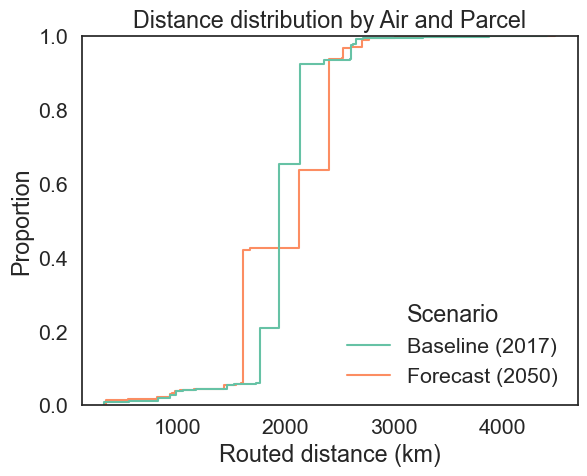

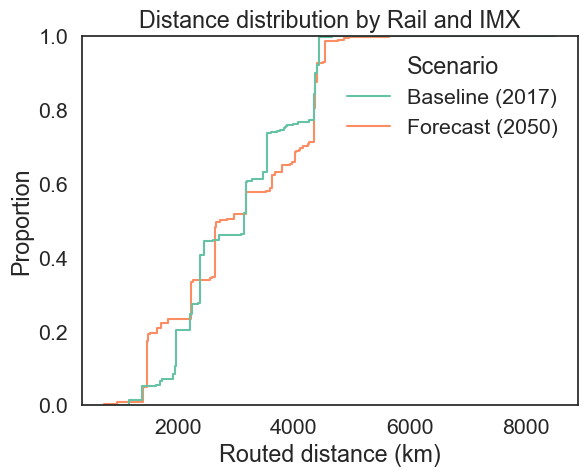

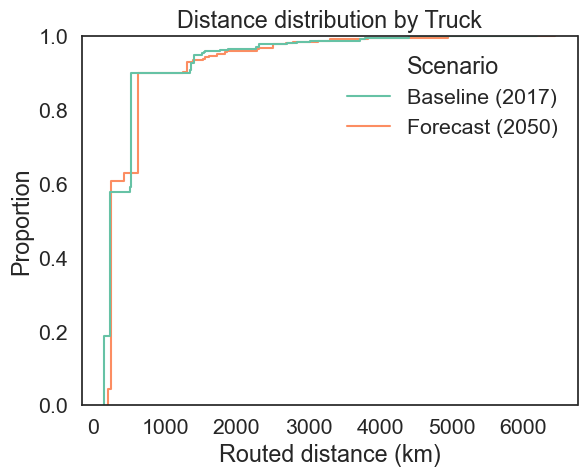

In [21]:
# plot distance
dist_by_mode_zone = pd.merge(modeled_results_by_mode_zone, 
                             tmile_results_by_mode_zone,
                            on = ['FAF', 'Mode', 'Scenario'], 
                             how = 'inner')
dist_by_mode_zone.loc[:, 'Distance'] = \
dist_by_mode_zone.loc[:, 'Ton-km'] / dist_by_mode_zone.loc[:, 'Load'] / 1000
print(dist_by_mode_zone.loc[:, 'Distance'].mean())
dist_by_mode_zone.head(5)

for mode in dist_by_mode_zone.Mode.unique():
    dist_by_mode_to_plot = dist_by_mode_zone.loc[dist_by_mode_zone['Mode'] == mode]
    ax=sns.ecdfplot(data=dist_by_mode_to_plot, x="Distance", 
                    weights = 'Load', hue="Scenario", palette = 'Set2')
    plt.title(f'Distance distribution by {mode}')
    # sns.move_legend(ax, loc="lower right")
    plt.xlabel('Routed distance (km)')
    plt.savefig(os.path.join(plot_dir, 'distance_distribution_by_' + mode + '.png'), dpi = 300, bbox_inches = 'tight' )
    
    plt.show()

3652.4784139622566


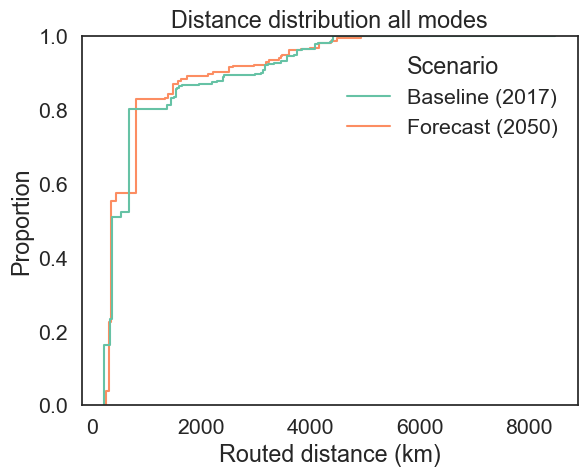

In [22]:
# # tonnage by zone
model_base_by_zone = \
gen_comm_summary(synthfirm_output_base, ['orig_FAFID'], 
                 'ShipmentLoad', 'Load', '2017',  'Baseline', add_total = False)

model_2050_by_zone = \
gen_comm_summary(synthfirm_output_2050, ['orig_FAFID'], 
                 'ShipmentLoad', 'Load', '2050', 'Forecast', add_total = False)

modeled_results_by_zone = \
pd.concat([model_base_by_zone, model_2050_by_zone])
modeled_results_by_zone.rename(columns = {'orig_FAFID': 'FAF'}, inplace = True)

tmile_base_by_zone = \
gen_comm_summary(synthfirm_output_base, 
                 ['orig_FAFID'], 'tmiles', 'Ton-km', '2017',  'Baseline', add_total = False)

tmile_2050_by_zone = \
gen_comm_summary(synthfirm_output_2050,
                 ['orig_FAFID'], 'tmiles', 'Ton-km', '2050', 'Forecast', add_total = False)

tmile_results_by_zone = \
pd.concat([tmile_base_by_zone, tmile_2050_by_zone])
tmile_results_by_zone.rename(columns = {'orig_FAFID': 'FAF'}, inplace = True)

# plot distance
dist_by_zone = pd.merge(modeled_results_by_zone, 
                        tmile_results_by_zone,
                            on = ['FAF', 'Scenario'], how = 'inner')
dist_by_zone.loc[:, 'Distance'] = dist_by_zone.loc[:, 'Ton-km'] / dist_by_zone.loc[:, 'Load'] / 1000
print(dist_by_zone.loc[:, 'Distance'].mean())


sns.ecdfplot(data=dist_by_zone, x="Distance", weights = 'Load', hue="Scenario", palette = 'Set2')
plt.title('Distance distribution all modes')
plt.xlabel('Routed distance (km)')
plt.savefig(os.path.join(plot_dir, 'distance_distribution_allmodes.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

## 2.2 FAF data processing

In [18]:
def gen_comm_by_faf(faf_df,  faf_zones_df, faf_name_lookup, 
                    zonal_id, col_attr, output_value, 
                    year_id, output_prefix):
    col_groups = faf_df[col_attr].unique().tolist()
    col_groups.append('total')
   
    metric_var = output_value + '_' + year_id
    tonnage_in_region = pd.pivot_table(faf_df, index =zonal_id,
                                          columns = col_attr, values = metric_var, aggfunc = 'sum')
    tonnage_in_region.loc[:, 'total'] = tonnage_in_region.sum(axis = 1) 
    tonnage_in_region = tonnage_in_region.reset_index()
    tonnage_in_region = tonnage_in_region.rename(columns = {zonal_id: 'FAF'})
    tonnage_in_region['FAF'] = \
    tonnage_in_region['FAF'].astype(np.int64)

    tonnage_in_region = pd.merge(tonnage_in_region, faf_name_lookup, 
                                   on = 'FAF', how = 'left')

    tonnage_by_FAF = \
    pd.merge(faf_zones_df, tonnage_in_region, on='FAF', how='left')
    tonnage_by_FAF.fillna(0, inplace = True)
    for attr in col_groups:
        attr_out = output_prefix + '_' + attr + '_per_area'
        tonnage_by_FAF.loc[:,attr_out] = \
        tonnage_by_FAF.loc[:, attr] * 0.907185/ \
        tonnage_by_FAF.loc[:, 'area']
    tonnage_by_FAF.drop(columns = col_groups, inplace = True)
    return(tonnage_by_FAF) 


In [19]:
# faf production by sctg
FAF_production_by_sctg_base = \
gen_comm_by_faf(faf_outflow, faf5_zones_df, faf_name_lookup, 
                'dms_orig', 'SCTG_Name', 'tons', '2017', '2017_prod')
FAF_production_by_sctg_2050 = \
gen_comm_by_faf(faf_outflow, faf5_zones_df, faf_name_lookup,
                'dms_orig', 'SCTG_Name', 'tons', '2050', '2050_prod')


In [20]:
# faf production by mode
FAF_production_by_mode_base = \
gen_comm_by_faf(faf_outflow, faf5_zones_df, faf_name_lookup,
                'dms_orig', 'Mode', 'tons', '2017', '2017_prod')
FAF_production_by_mode_2050 = \
gen_comm_by_faf(faf_outflow, faf5_zones_df, faf_name_lookup,
                'dms_orig', 'Mode', 'tons', '2050', '2050_prod')


In [21]:
# faf consumption by sctg
FAF_consumption_by_sctg_base = \
gen_comm_by_faf(faf_inflow, faf5_zones_df, faf_name_lookup,
                'dms_dest', 'SCTG_Name', 'tons', '2017', '2017_cons')
FAF_consumption_by_sctg_2050 = \
gen_comm_by_faf(faf_inflow, faf5_zones_df, faf_name_lookup,
                'dms_dest', 'SCTG_Name', 'tons', '2050', '2050_cons')


In [22]:
# faf consumption by mode
FAF_consumption_by_mode_base = \
gen_comm_by_faf(faf_inflow, faf5_zones_df, faf_name_lookup,
                'dms_dest', 'Mode', 'tons', '2017', '2017_cons')
FAF_consumption_by_mode_2050 = \
gen_comm_by_faf(faf_inflow, faf5_zones_df, faf_name_lookup,
                'dms_dest', 'Mode', 'tons', '2050', '2050_cons')


In [23]:
def gen_faf_summary(faf_df,  group_var, output_value, output_name, year_id, scenario, add_total = True):
    metric = output_value + "_" + year_id
    faf_by_sector = faf_df.groupby(group_var)[metric].sum()
    
    if add_total:
        faf_by_sector.loc['total'] = faf_by_sector.sum()
    faf_by_sector = faf_by_sector.reset_index()  
      
    #print(faf_by_sector.head(5))
    if output_name == 'Load':
        faf_by_sector[metric] *= us_ton_to_ton
        
    if output_name == 'Ton-km':
        unit_converter = us_ton_to_ton * miles_to_km * 1000000
        faf_by_sector[metric] *=  unit_converter # convert from million ton mile to ton-km
  
    faf_by_sector.rename(columns = {metric: output_name}, inplace = True)
    faf_by_sector.loc[:, 'Scenario'] = f'{scenario} ({year_id})'
    faf_by_sector[output_name] *=us_ton_to_ton # convert to metric tons
    return(faf_by_sector)

# tonnage production by SCTG
faf_base_prod_by_sctg = \
gen_faf_summary(faf_outflow, ['SCTG_Name'], 'tons', 'Load', 
                '2017',  'Baseline')

faf_2050_prod_by_sctg = \
gen_faf_summary(faf_outflow, ['SCTG_Name'], 'tons', 
                'Load', '2050', 'Forecast')


faf_prod_by_sctg = pd.concat([faf_base_prod_by_sctg, 
                              faf_2050_prod_by_sctg])
faf_prod_by_sctg.loc[:, 'Source'] = 'FAF5'

# tonnage production by mode
faf_base_prod_by_mode = \
gen_faf_summary(faf_outflow, ['Mode'], 'tons', 'Load', 
                '2017',  'Baseline', add_total = False)

faf_2050_prod_by_mode = \
gen_faf_summary(faf_outflow, ['Mode'], 'tons', 'Load', 
                '2050', 'Forecast', add_total = False)

faf_prod_by_mode = pd.concat([faf_base_prod_by_mode, faf_2050_prod_by_mode])
faf_prod_by_mode.loc[:, 'Source'] = 'FAF5'


In [24]:
# tonnage consumption by SCTG
faf_base_cons_by_sctg = \
gen_faf_summary(faf_inflow, ['SCTG_Name'], 'tons', 'Load', 
                '2017',  'Baseline')

faf_2050_cons_by_sctg = \
gen_faf_summary(faf_inflow, ['SCTG_Name'], 'tons', 
                'Load', '2050', 'Forecast')


faf_cons_by_sctg = pd.concat([faf_base_cons_by_sctg, 
                              faf_2050_cons_by_sctg])
faf_cons_by_sctg.loc[:, 'Source'] = 'FAF5'

# tonnage consumption by mode
faf_base_cons_by_mode = \
gen_faf_summary(faf_inflow, ['Mode'], 'tons', 'Load', 
                '2017',  'Baseline', add_total = False)

faf_2050_cons_by_mode = \
gen_faf_summary(faf_inflow, ['Mode'], 'tons', 'Load', 
                '2050', 'Forecast', add_total = False)

faf_cons_by_mode = pd.concat([faf_base_cons_by_mode, faf_2050_cons_by_mode])
faf_cons_by_mode.loc[:, 'Source'] = 'FAF5'


In [40]:
# tonnage by SCTG
faf_base_by_sctg_zone = \
gen_faf_summary(faf_outflow, ['dms_orig', 'SCTG_Name'], 
                'tons', 'Load', '2017',  'Baseline_FAF5', add_total = False)

faf_2050_by_sctg_zone = \
gen_faf_summary(faf_outflow, ['dms_orig', 'SCTG_Name'], 
                'tons', 'Load', '2050', 'Forecast_FAF5', add_total = False)

faf_results_by_sctg_zone = \
pd.concat([faf_base_by_sctg_zone, faf_2050_by_sctg_zone])
faf_results_by_sctg_zone.rename(columns = {'dms_orig': 'FAF'}, inplace = True)

faf_results_by_sctg_zone.head(5)

FAF    SCTG_Name          Load              Scenario
0  411         bulk  36036.052570  Baseline_FAF5 (2017)
1  411    fuel_fert  10182.407165  Baseline_FAF5 (2017)
2  411  interm_food  11416.829788  Baseline_FAF5 (2017)
3  411    mfr_goods  11269.344033  Baseline_FAF5 (2017)
4  411        other   6893.383385  Baseline_FAF5 (2017)

# 3 - Result visualization

## 3.1 FAF and SynthFirm comparison

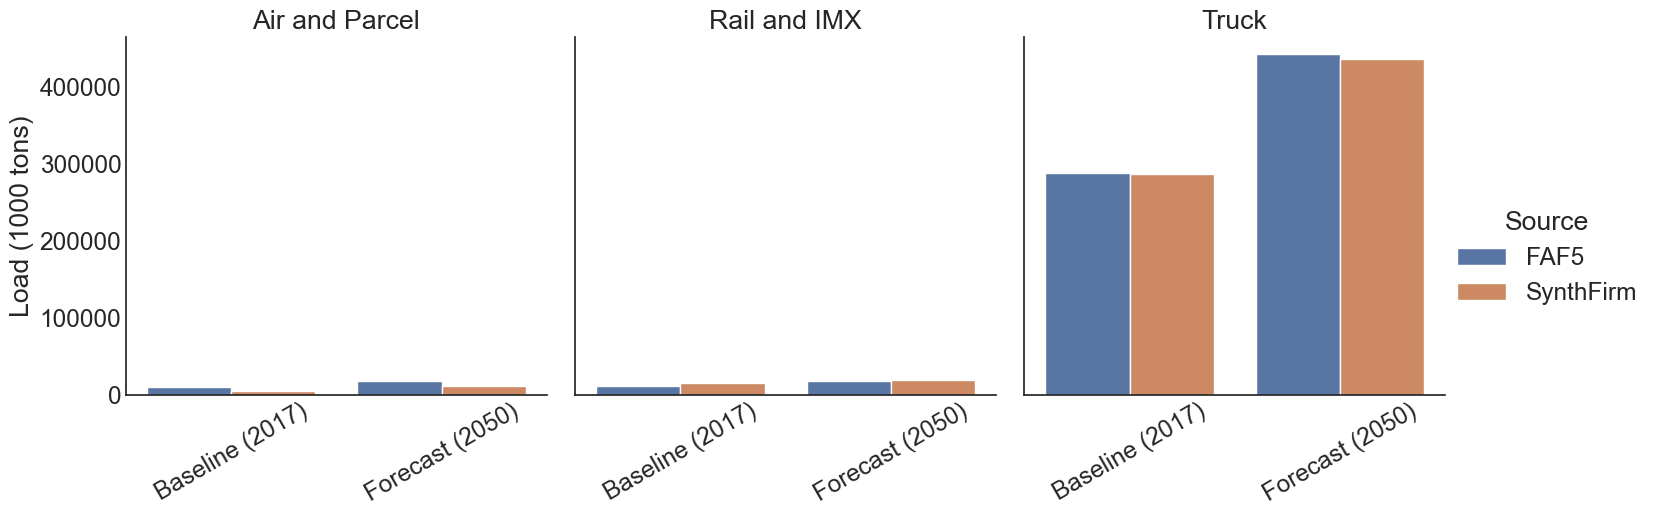

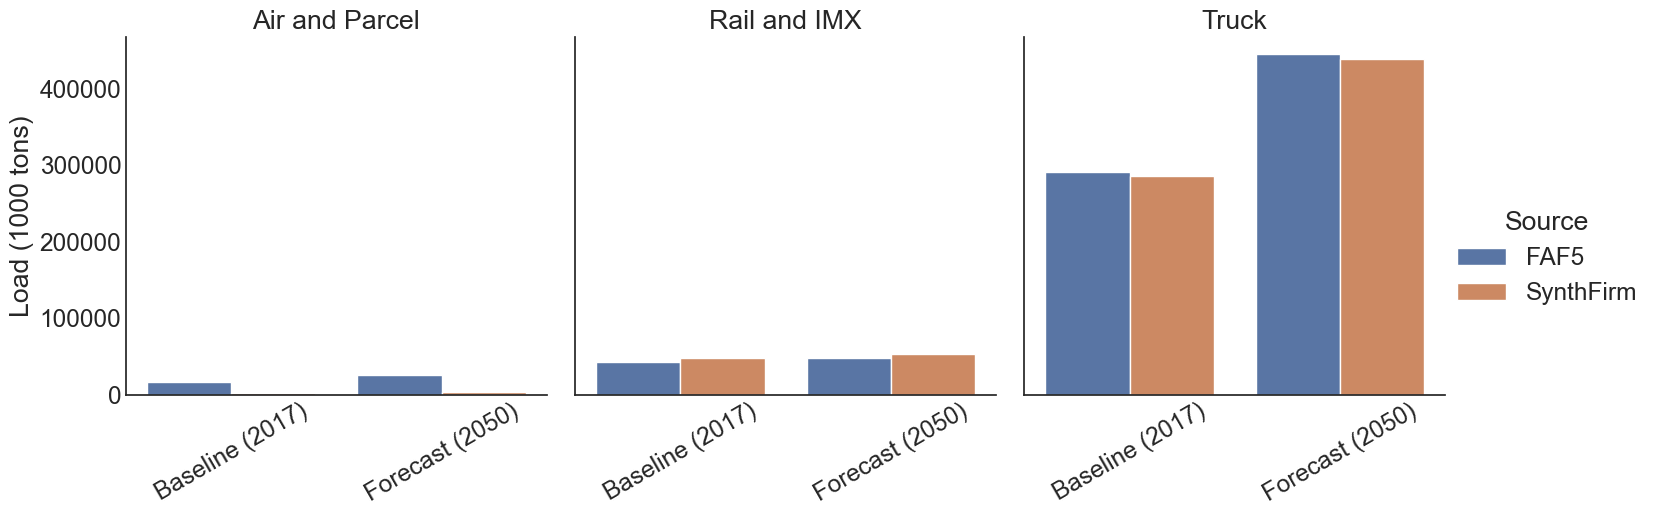

In [26]:
# compare absolute value by scenario

# mode

# production
prod_comparison_by_mode = \
pd.concat([faf_prod_by_mode, modeled_prod_by_mode])

sns.set(font_scale=1.6)
plt.style.use('seaborn-v0_8-white')
sns.set_style("white")
ax = sns.catplot(prod_comparison_by_mode, x = 'Scenario', hue = 'Source', y = 'Load',col = 'Mode', kind = 'bar')
ax.set_titles("{col_name}")
ax.set_axis_labels(y_var='Load (1000 tons)')
for axn in ax.axes.flat:
    axn.set_xlabel('')
    for label in axn.get_xticklabels():
        label.set_rotation(30)
plt.savefig(os.path.join(plot_dir, 'production_comparison_by_mode.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

# consumption
cons_comparison_by_mode = \
pd.concat([faf_cons_by_mode, modeled_cons_by_mode])

sns.set(font_scale=1.6)
plt.style.use('seaborn-v0_8-white')
sns.set_style("white")
ax = sns.catplot(cons_comparison_by_mode, x = 'Scenario', hue = 'Source', y = 'Load',col = 'Mode', kind = 'bar')
ax.set_titles("{col_name}")
ax.set_axis_labels(y_var='Load (1000 tons)')
for axn in ax.axes.flat:
    axn.set_xlabel('')
    for label in axn.get_xticklabels():
        label.set_rotation(30)
plt.savefig(os.path.join(plot_dir, 'consumption_comparison_by_mode.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

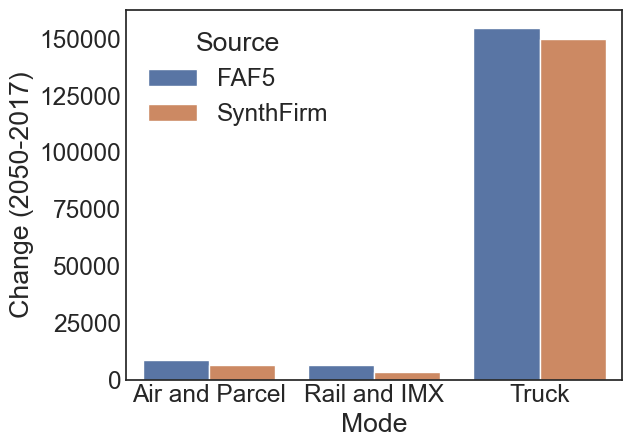

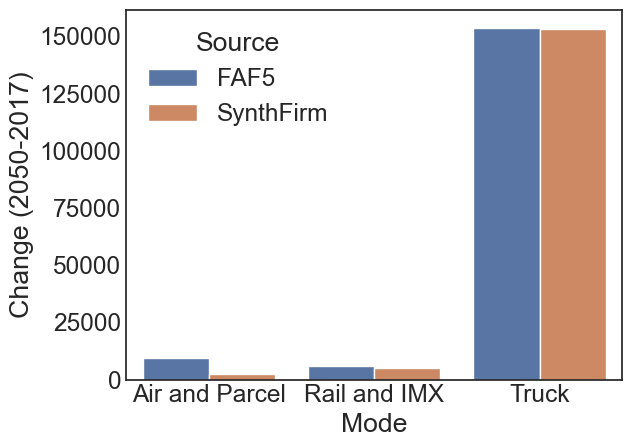

In [29]:
delta_production_by_mode = pd.pivot_table(prod_comparison_by_mode, 
                                          index = ['Mode', 'Source'],
                                         columns = 'Scenario', 
                                          values = 'Load', 
                                          aggfunc = 'sum').reset_index()

delta_production_by_mode.loc[:, 'Change (2050-2017)'] = \
delta_production_by_mode.loc[:, 'Forecast (2050)'] - \
delta_production_by_mode.loc[:, 'Baseline (2017)']

ax = sns.barplot(delta_production_by_mode, x = 'Mode', 
                 hue = 'Source', y = 'Change (2050-2017)')

plt.savefig(os.path.join(plot_dir, 'delta_prod_comparison_by_mode.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

delta_consumption_by_mode = pd.pivot_table(cons_comparison_by_mode, 
                                          index = ['Mode', 'Source'],
                                         columns = 'Scenario', 
                                          values = 'Load', 
                                          aggfunc = 'sum').reset_index()

delta_consumption_by_mode.loc[:, 'Change (2050-2017)'] = \
delta_consumption_by_mode.loc[:, 'Forecast (2050)'] - \
delta_consumption_by_mode.loc[:, 'Baseline (2017)']

ax = sns.barplot(delta_consumption_by_mode, x = 'Mode', 
                 hue = 'Source', y = 'Change (2050-2017)')

plt.savefig(os.path.join(plot_dir, 'delta_cons_comparison_by_mode.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

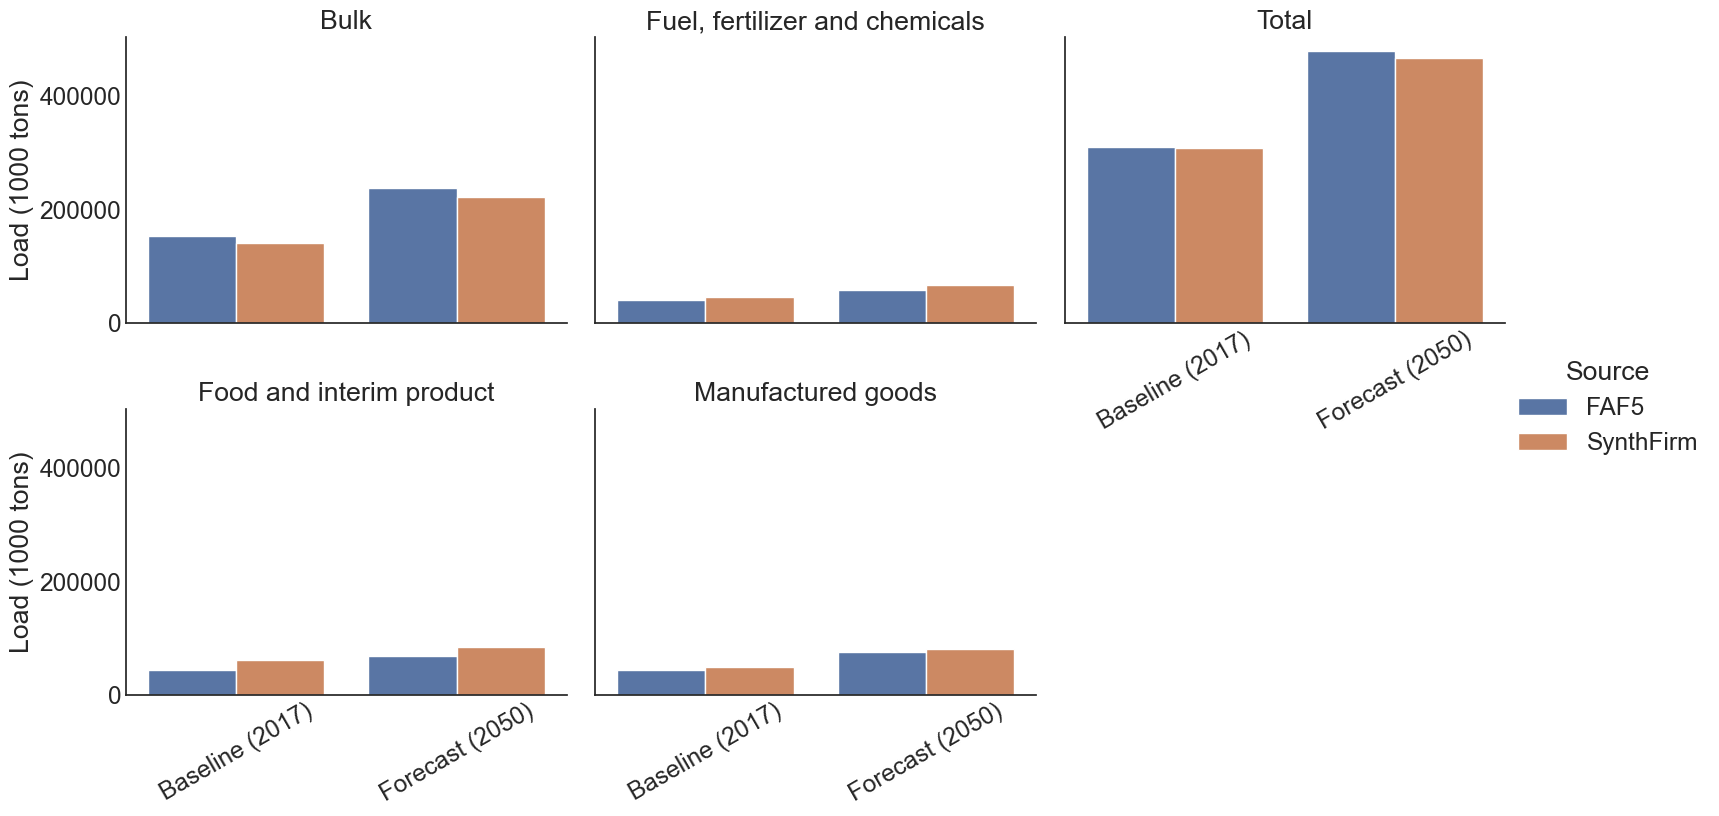

In [32]:
# SCTG

# production
prod_comparison_by_sctg = \
pd.concat([faf_prod_by_sctg, modeled_prod_by_sctg])

prod_comparison_by_sctg = \
prod_comparison_by_sctg.loc[prod_comparison_by_sctg['SCTG_Name'] != 'other']
commodity_label['total'] = 'Total'
prod_comparison_by_sctg.loc[:, 'Commodity'] = \
prod_comparison_by_sctg.loc[:, 'SCTG_Name'].map(commodity_label)

sns.set(font_scale=1.6)
plt.style.use('seaborn-v0_8-white')
sns.set_style("white")

col_orders = ['Bulk', 'Fuel, fertilizer and chemicals', 'Total', 'Food and interim product',  'Manufactured goods']
ax = sns.catplot(prod_comparison_by_sctg, x = 'Scenario', hue = 'Source', y = 'Load',col = 'Commodity',
                col_wrap = 3, col_order = col_orders, kind = 'bar', height = 4, aspect = 1.3)
ax.set_titles("{col_name}")
ax.set_axis_labels(y_var='Load (1000 tons)')
for axn in ax.axes.flat:
    axn.set_xlabel('')
    for label in axn.get_xticklabels():
        label.set_rotation(30)
# sns.move_legend(ax, "lower right", bbox_to_anchor=(0.8, 0.1))
plt.savefig(os.path.join(plot_dir, 'prod_comparison_by_sctg.png'), dpi = 300, bbox_inches = 'tight')
plt.show()


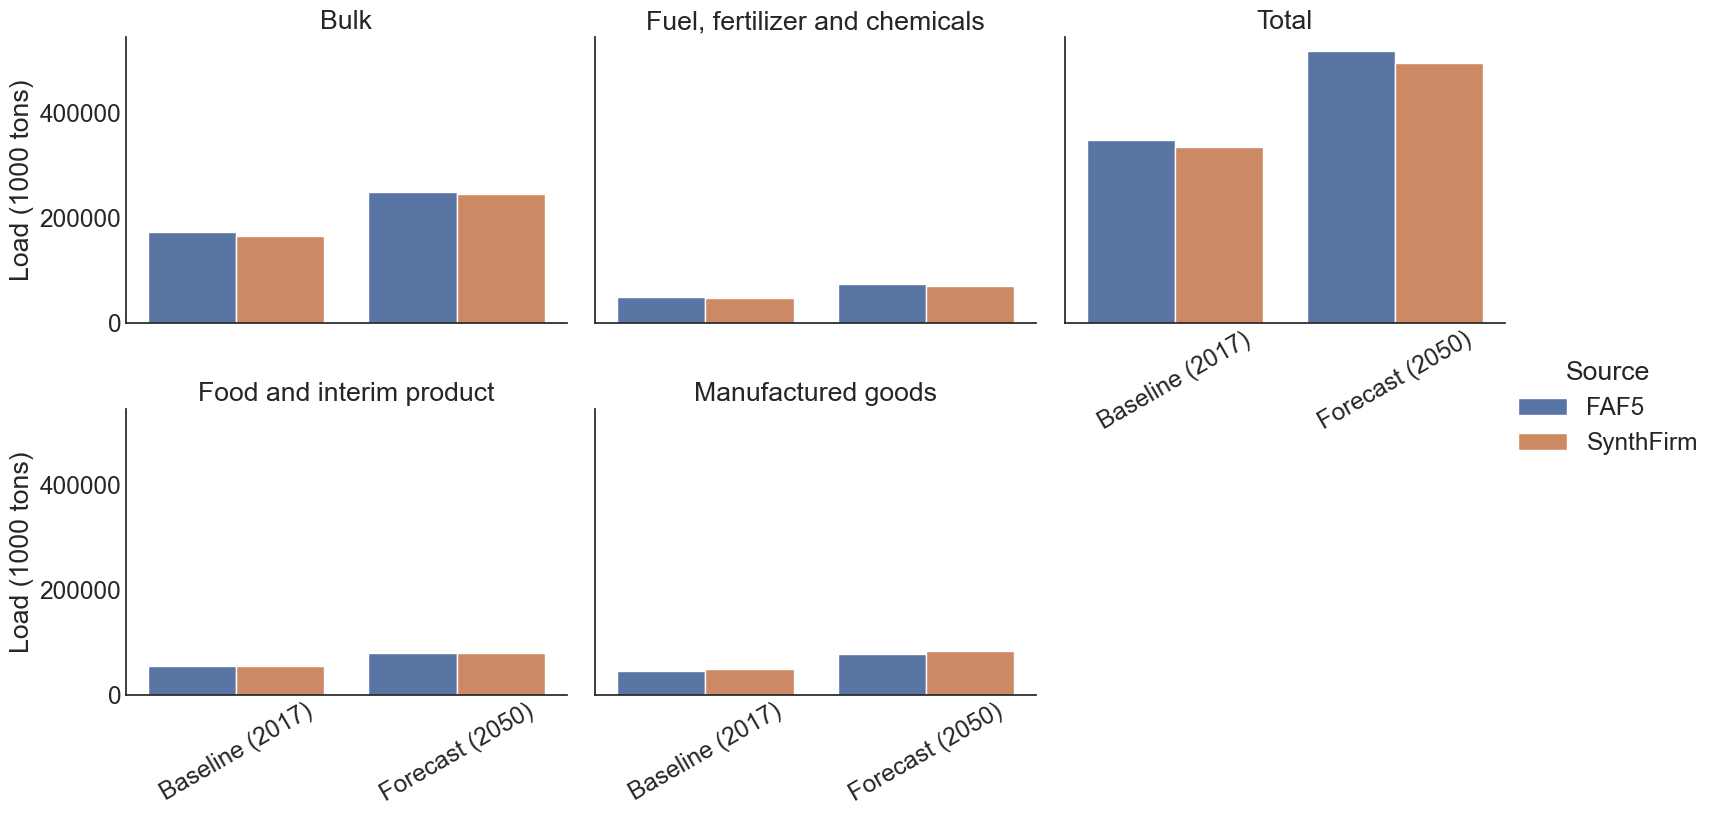

In [33]:
# consumption
cons_comparison_by_sctg = \
pd.concat([faf_cons_by_sctg, modeled_cons_by_sctg])

cons_comparison_by_sctg = \
cons_comparison_by_sctg.loc[cons_comparison_by_sctg['SCTG_Name'] != 'other']
commodity_label['total'] = 'Total'
cons_comparison_by_sctg.loc[:, 'Commodity'] = \
cons_comparison_by_sctg.loc[:, 'SCTG_Name'].map(commodity_label)


col_orders = ['Bulk', 'Fuel, fertilizer and chemicals', 'Total', 'Food and interim product',  'Manufactured goods']
ax = sns.catplot(cons_comparison_by_sctg, x = 'Scenario', hue = 'Source', y = 'Load',col = 'Commodity',
                col_wrap = 3, col_order = col_orders, kind = 'bar', height = 4, aspect = 1.3)
ax.set_titles("{col_name}")
ax.set_axis_labels(y_var='Load (1000 tons)')
for axn in ax.axes.flat:
    axn.set_xlabel('')
    for label in axn.get_xticklabels():
        label.set_rotation(30)
# sns.move_legend(ax, "lower right", bbox_to_anchor=(0.8, 0.1))
plt.savefig(os.path.join(plot_dir, 'cons_comparison_by_sctg.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

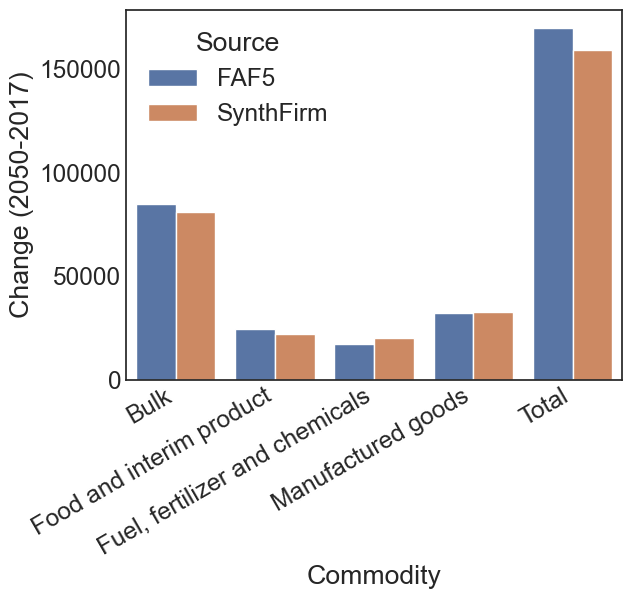

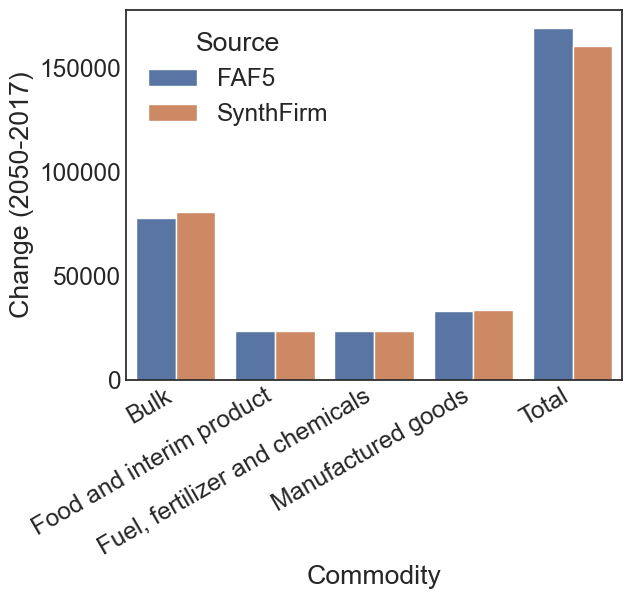

In [35]:
delta_prod_by_sctg = pd.pivot_table(prod_comparison_by_sctg, 
                                    index = ['Commodity', 'Source'],
                                         columns = 'Scenario', values = 'Load', aggfunc = 'sum').reset_index()

delta_prod_by_sctg.loc[:, 'Change (2050-2017)'] = \
delta_prod_by_sctg.loc[:, 'Forecast (2050)'] - \
delta_prod_by_sctg.loc[:, 'Baseline (2017)']

ax = sns.barplot(delta_prod_by_sctg, x = 'Commodity', 
                 hue = 'Source', y = 'Change (2050-2017)')
plt.xticks(rotation = 30, ha = 'right')
plt.savefig(os.path.join(plot_dir, 'delta_prod_comparison_by_sctg.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

delta_cons_by_sctg = pd.pivot_table(cons_comparison_by_sctg,
                                    index = ['Commodity', 'Source'],
                                    columns = 'Scenario', 
                                    values = 'Load', 
                                    aggfunc = 'sum').reset_index()

delta_cons_by_sctg.loc[:, 'Change (2050-2017)'] = \
delta_cons_by_sctg.loc[:, 'Forecast (2050)'] - \
delta_cons_by_sctg.loc[:, 'Baseline (2017)']

ax = sns.barplot(delta_cons_by_sctg, x = 'Commodity', 
                 hue = 'Source', y = 'Change (2050-2017)')
plt.xticks(rotation = 30, ha = 'right')
plt.savefig(os.path.join(plot_dir, 'delta_cons_comparison_by_sctg.png'), dpi = 300, bbox_inches = 'tight')
plt.show()

## 3.2 Visualization of SynthFirm results

### base distribution

In [26]:
# define map plot by county
def plot_region_map(region_gdf, column, title,
                    filename, logscale = True, 
                    vmin=0, vmax=50, legend_scale = 0.8, 
                    alpha=0.5, cmap='viridis'):
    """
    Plots a choropleth map of firm density and adds a basemap.
    
    Parameters:
        region_gdf: GeoDataFrame
            The geodataframe with polygon regions and firm attr column.
        column: str
            Name of the column for density.
        filename: str
            Output filename.
        logscale: boolean
            If use logscale for color ramp
        vmin, vmax: float
            Color scale min and max.
        alpha: float
            Polygon alpha.
        cmap: str
            Colormap.
    """
    if cmap == 'viridis':
        facecolor ='#440154'
    else:
        facecolor = 'None'
    sns.set(font_scale=1.2)
    ax = region_gdf.plot(facecolor=facecolor, linewidth = 0.001)
    if logscale is True:
        region_gdf.plot(
            figsize=(6, 4.5),
            ax=ax,
            column=column,
            norm=matplotlib.colors.LogNorm(vmin=0.001, vmax=vmax),
            alpha=alpha,
            legend=True,
            cmap=cmap,
            linewidth=0.001,
            legend_kwds={'shrink': legend_scale},
            edgecolor='none'
        )
    else:
        region_gdf.plot(
            figsize=(6, 4.5),
            ax = ax,
            column=column,
            vmin=vmin, vmax=vmax,
            alpha=alpha,
            legend=True,
            cmap=cmap,
            linewidth=0.001,
            legend_kwds={'shrink': legend_scale},
            edgecolor='none')

    ax.grid(False)
    ax.axis('off')
    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [21]:
production_by_sctg_base.drop(columns = ['area'], inplace = True)
consumption_by_sctg_base.drop(columns = ['area'], inplace = True)

production_by_sctg_2050.drop(columns = ['area'], inplace = True)
consumption_by_sctg_2050.drop(columns = ['area'], inplace = True)

2050_prod interm_food


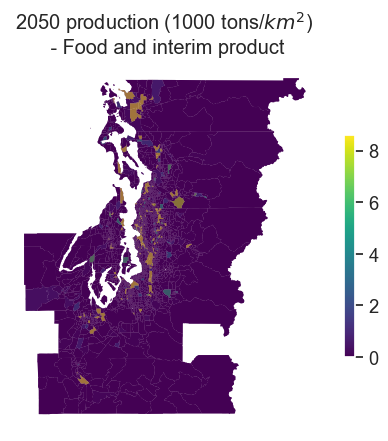

2050_prod bulk


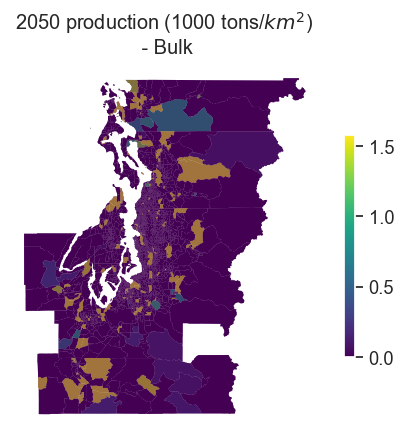

2050_prod mfr_goods


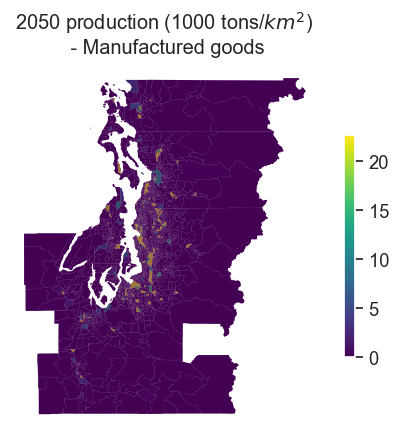

2050_prod fuel_fert


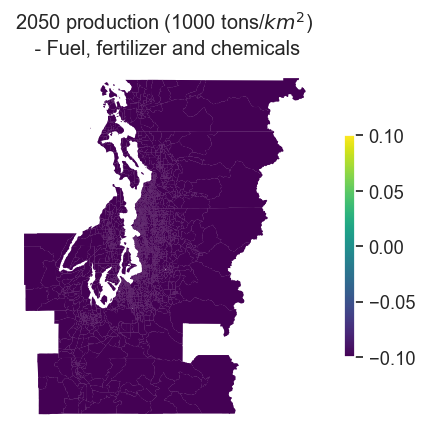

2050_prod total


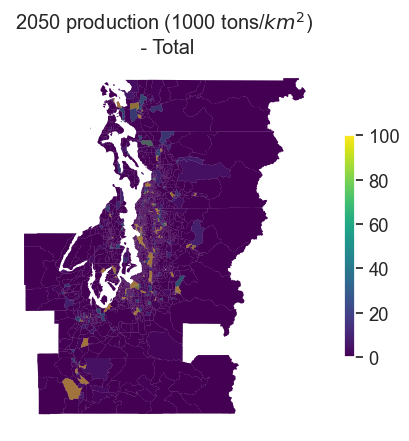

2050_cons interm_food


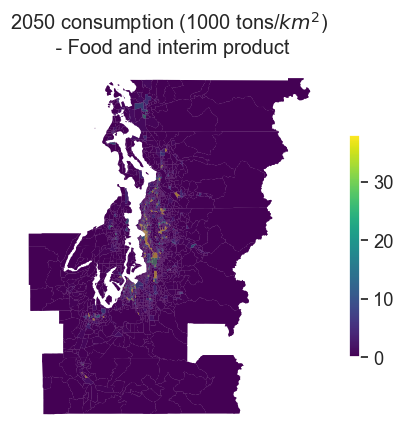

2050_cons bulk


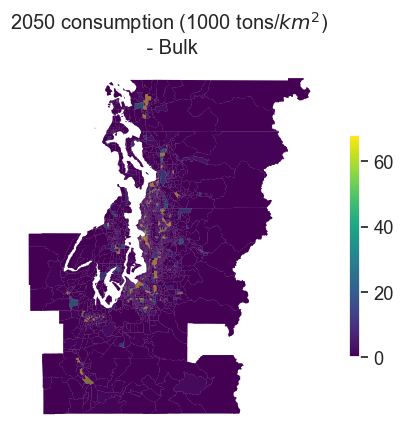

2050_cons mfr_goods


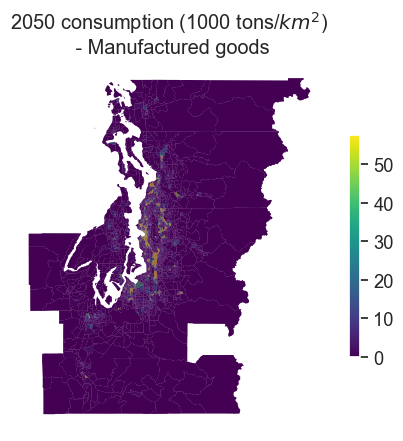

2050_cons fuel_fert


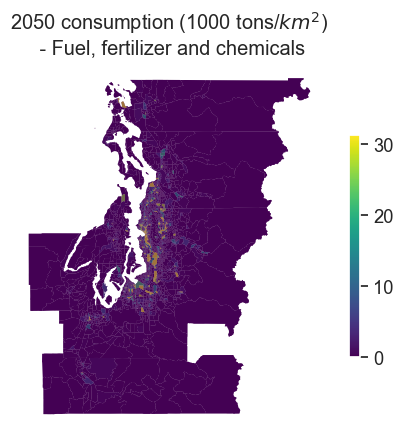

2050_cons total


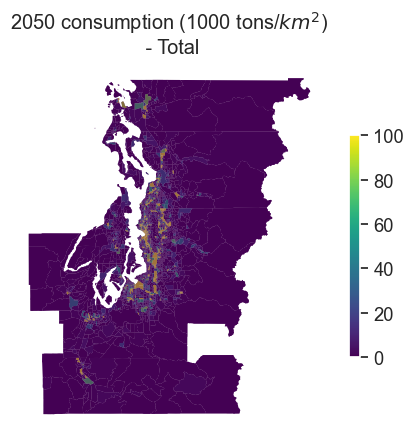

In [32]:
# baseline map by SCTG
region_map_with_cf = \
region_map.merge(production_by_sctg_2050, 
                 on = 'MESOZONE', how='left')

region_map_with_cf = \
region_map_with_cf.merge(consumption_by_sctg_2050, 
                         on = 'MESOZONE', how='left')

var_to_plot = ['2050_prod_interm_food_per_area', '2050_prod_bulk_per_area',
       '2050_prod_mfr_goods_per_area', '2050_prod_fuel_fert_per_area',
       '2050_prod_total_per_area',
       '2050_cons_interm_food_per_area', '2050_cons_bulk_per_area',
       '2050_cons_mfr_goods_per_area', '2050_cons_fuel_fert_per_area',
       '2050_cons_total_per_area']

metric_lookup = {'2050_prod': '2050 production',
                 '2050_cons': '2050 consumption'}

def name_parcer(s):
    words = s.split('_')
    if len(words) <= 4:
        SCTG_Group =  ''  # Not enough words to remove
        prefix = ''
    else:
        SCTG_Group = '_'.join(words[2:-2])  
        prefix = '_'.join(words[0:2])
    return prefix, SCTG_Group  

unit = '1000 tons/$km^{2}$'
# Apply the function
for var in var_to_plot:
    prefix, SCTG_group = name_parcer(var)
    
    print(prefix, SCTG_group)
    title_prefix = metric_lookup[prefix]
    if SCTG_group == 'total':
        title = f'{title_prefix} ({unit}) \n - Total'
        vmax = 100
    else:
        commodity = commodity_label[SCTG_group]
        title = f'{title_prefix} ({unit}) \n - {commodity}'
        vmax = 1.05 * region_map_with_cf[var].quantile(0.95)
    filename = os.path.join(plot_dir, prefix + '_' + SCTG_group + '_by_zone.png')
    plot_region_map(region_map_with_cf, var, title,
                    filename, logscale = False, 
                    vmin=0, vmax=vmax, legend_scale = 0.6, alpha=0.5, cmap='viridis')

In [22]:
production_by_mode_base.drop(columns = ['area'], inplace = True)
consumption_by_mode_base.drop(columns = ['area'], inplace = True)

Index(['GEOID_x', 'FAFID_x', 'MESOZONE', 'CBPZONE_x', 'geometry', 'area_x',
       'GEOID_y', 'FAFID_y', 'CBPZONE_y', 'area_y', '2050_prod_Truck_per_area',
       '2050_prod_Air and Parcel_per_area', '2050_prod_Rail and IMX_per_area',
       '2050_prod_total_per_area', 'GEOID', 'FAFID', 'CBPZONE', 'area',
       '2050_cons_Air and Parcel_per_area', '2050_cons_Truck_per_area',
       '2050_cons_Rail and IMX_per_area', '2050_cons_total_per_area'],
      dtype='object')
2050_prod Truck


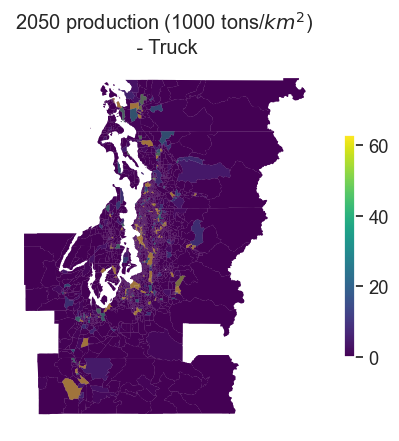

2050_prod Rail and IMX


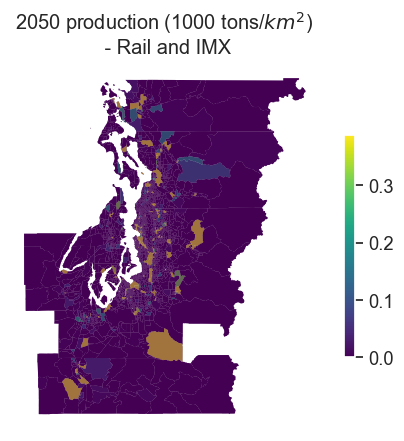

2050_prod Air and Parcel


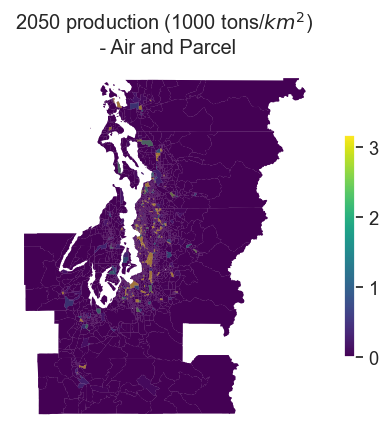

2050_cons Truck


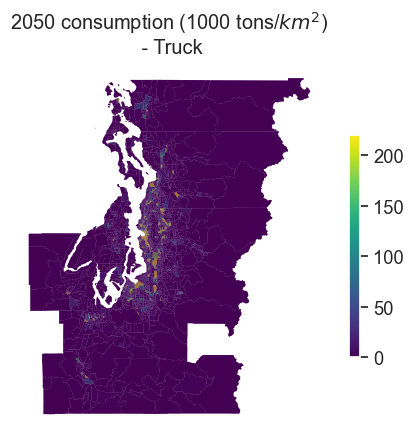

2050_cons Rail and IMX


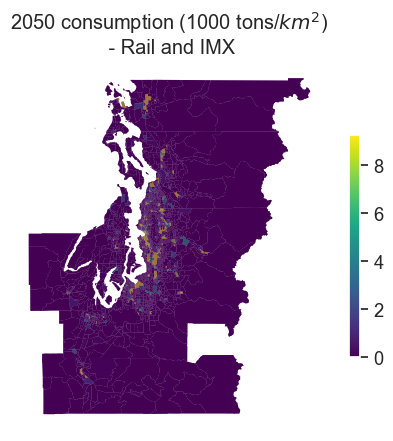

2050_cons Air and Parcel


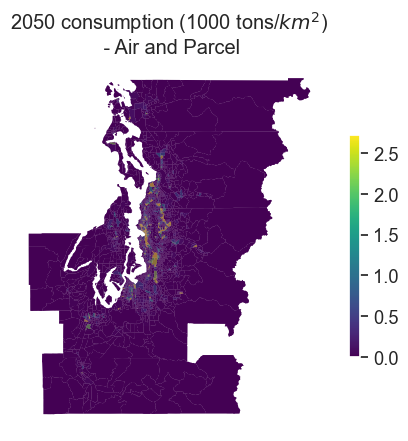

In [31]:
# baseline map by mode
region_map_with_cf = \
region_map.merge(production_by_mode_2050, 
                 on = 'MESOZONE', how='left')

region_map_with_cf = \
region_map_with_cf.merge(consumption_by_mode_2050, 
                         on = 'MESOZONE', how='left')

print(region_map_with_cf.columns)
var_to_plot = ['2050_prod_Truck_per_area',
       '2050_prod_Rail and IMX_per_area', 
               '2050_prod_Air and Parcel_per_area',
       '2050_cons_Truck_per_area', 
               '2050_cons_Rail and IMX_per_area',
       '2050_cons_Air and Parcel_per_area']



unit = '1000 tons/$km^{2}$'
# Apply the function
for var in var_to_plot:
    prefix, mode = name_parcer(var)
    
    print(prefix, mode)
    title_prefix = metric_lookup[prefix]
    title = f'{title_prefix} ({unit}) \n - {mode}'
    vmax = 1.05 * region_map_with_cf[var].quantile(0.95)
    filename = os.path.join(plot_dir, prefix + '_' + mode + '_by_zone.png')
    plot_region_map(region_map_with_cf, var, title,
                    filename, logscale = False, 
                    vmin=0, vmax=vmax, legend_scale = 0.6, alpha=0.5, cmap='viridis')

### base versus disruption

In [33]:
# scenario: left - right
plot_pairs = {'Production change (2050-2017)': ('2050_prod_', '2017_prod_'),
             'Consumption change (2050-2017)': ('2050_cons_', '2017_cons_')}

output_prefix = {'Production change (2050-2017)': 'prod_delta_2050_2017_',
             'Consumption change (2050-2017)': 'cons_delta_2050_2017_'}

unit = '1000 tons/$km^{2}$'

In [37]:
production_by_sctg_base.drop(columns = ['FAFID','CBPZONE', 'GEOID'], inplace = True)  
production_by_sctg_2050.drop(columns = ['FAFID','CBPZONE', 'GEOID'], inplace = True)  
consumption_by_sctg_base.drop(columns = ['FAFID','CBPZONE', 'GEOID'], inplace = True)  
consumption_by_sctg_2050.drop(columns = ['FAFID','CBPZONE', 'GEOID'], inplace = True) 

In [38]:
# generate dataset

commodity_change_comparison = \
region_map.merge(production_by_sctg_base,
                 on = ['MESOZONE'], how = 'left')

commodity_change_comparison = \
commodity_change_comparison.merge(production_by_sctg_2050,
                                  on = ['MESOZONE'], how = 'left')

commodity_change_comparison = \
commodity_change_comparison.merge(consumption_by_sctg_base, 
                                     on = ['MESOZONE'], how = 'left')

commodity_change_comparison = \
commodity_change_comparison.merge(consumption_by_sctg_2050,
                                     on = ['MESOZONE'], how = 'left')

commodity_change_comparison.head(5)

GEOID  FAFID      MESOZONE  CBPZONE  \
0  530330293053    531  530330293053    53033   
1  530330205002    531  530330205002    53033   
2  530530620003    531  530530620003    53053   
3  530530613002    531  530530613002    53053   
4  530610527055    531  530610527055    53061   

                                            geometry    area_x  \
0  MULTIPOLYGON (((-122.21292 47.42784, -122.2129...  0.891907   
1  MULTIPOLYGON (((-122.31347 47.75749, -122.3085...  0.435127   
2  MULTIPOLYGON (((-122.42101 47.23054, -122.4164...  0.291051   
3  MULTIPOLYGON (((-122.46102 47.25418, -122.4538...  0.254453   
4  MULTIPOLYGON (((-122.14090 48.04966, -122.1408...  0.595708   

   2017_prod_mfr_goods_per_area  2017_prod_interm_food_per_area  \
0                           0.0                             0.0   
1                           0.0                             0.0   
2                           0.0                             0.0   
3                           0.0                             0.0   
4                           0.0                             0.0   

   2017_prod_bulk_per_area  2017_prod_fuel_fert_per_area  ...  \
0                      0.0                           0.0  ...   
1                      0.0                           0.0  ...   
2                      0.0                           0.0  ...   
3                      0.0                           0.0  ...   
4                      0.0                           0.0  ...   

   2017_cons_bulk_per_area  2017_cons_other_per_area  \
0                      0.0                       0.0   
1                      0.0                       0.0   
2                      0.0                       0.0   
3                      0.0                       0.0   
4                      0.0                       0.0   

   2017_cons_total_per_area      area  2050_cons_mfr_goods_per_area  \
0                  1.564373  0.891907                      3.851699   
1                  1.609091  0.435127                      0.680480   
2                  2.490917  0.291051                      0.062882   
3                 39.200677  0.254453                      0.547554   
4                  0.000000  0.595708                      0.000000   

   2050_cons_interm_food_per_area  2050_cons_bulk_per_area  \
0                        0.000000                      0.0   
1                        0.613052                      0.0   
2                        0.000000                      0.0   
3                        2.747547                      0.0   
4                        0.000000                      0.0   

   2050_cons_other_per_area  2050_cons_fuel_fert_per_area  \
0                       0.0                        0.0000   
1                       0.0                        0.0000   
2                       0.0                        0.0000   
3                       0.0                        2.3789   
4                       0.0                        0.0000   

   2050_cons_total_per_area  
0                  3.851699  
1                  1.293531  
2                  0.062882  
3                  5.674000  
4                  0.000000  

[5 rows x 32 columns]

Production change (2050-2017) mfr_goods


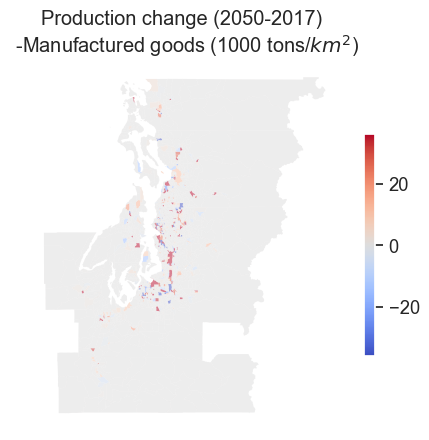

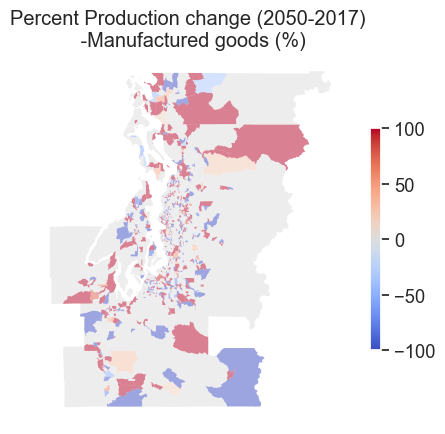

Production change (2050-2017) interm_food


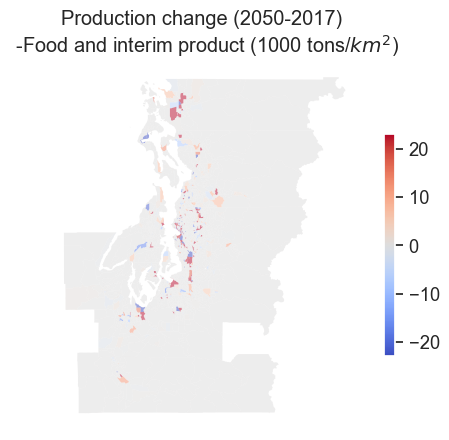

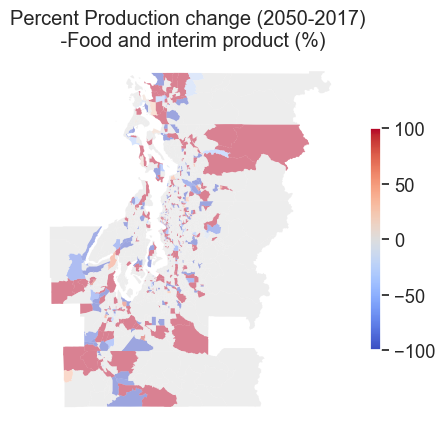

Production change (2050-2017) bulk


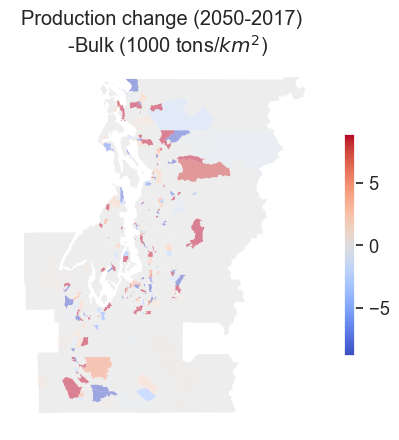

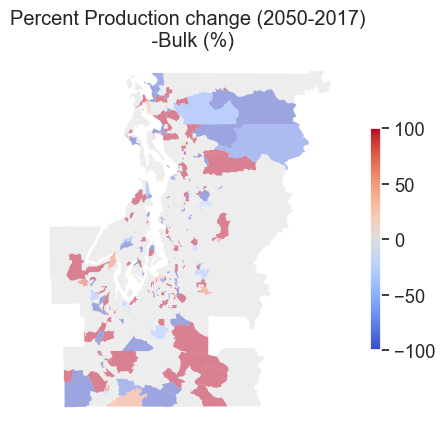

Production change (2050-2017) fuel_fert


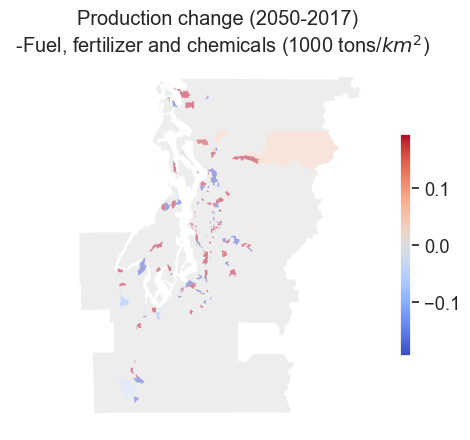

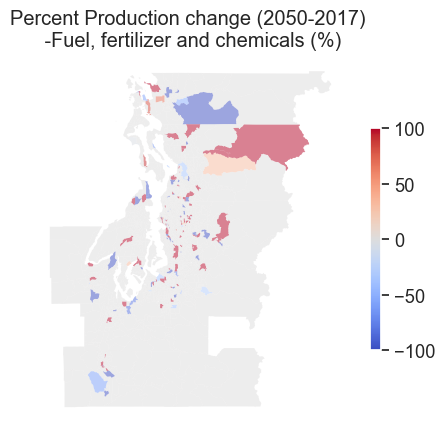

Production change (2050-2017) total


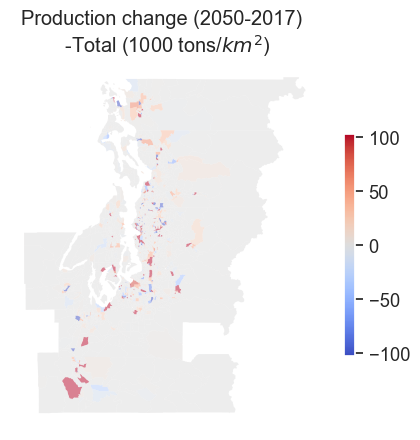

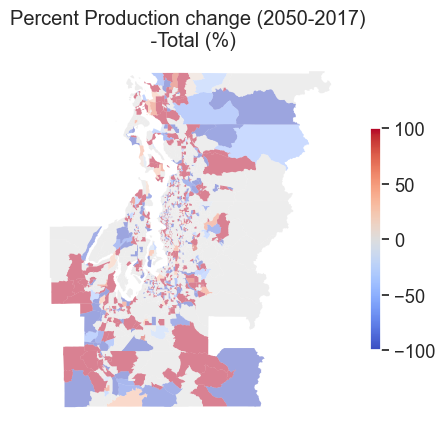

Consumption change (2050-2017) mfr_goods


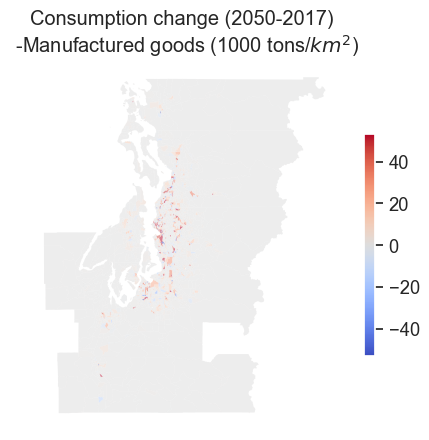

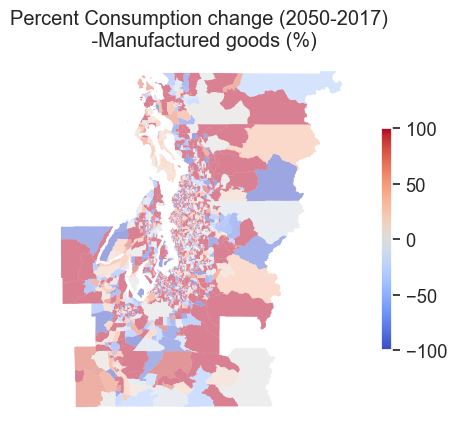

Consumption change (2050-2017) interm_food


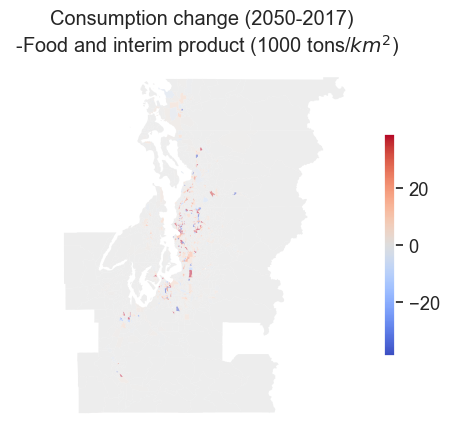

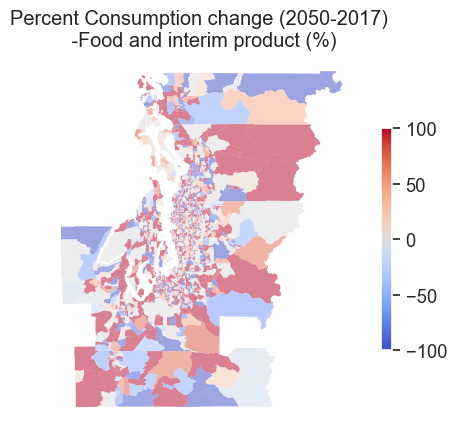

Consumption change (2050-2017) bulk


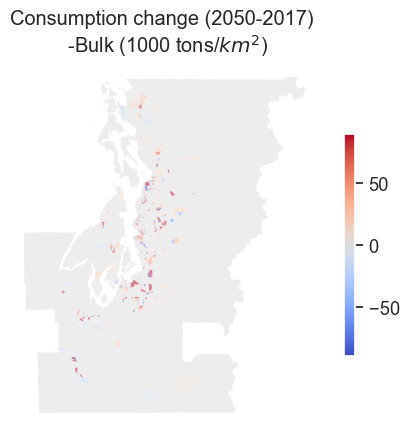

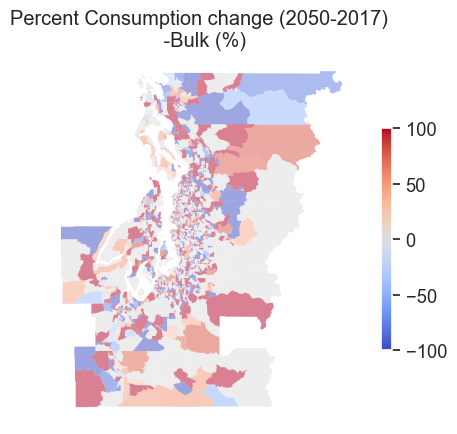

Consumption change (2050-2017) fuel_fert


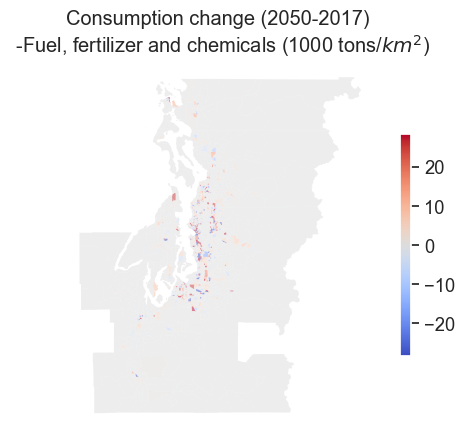

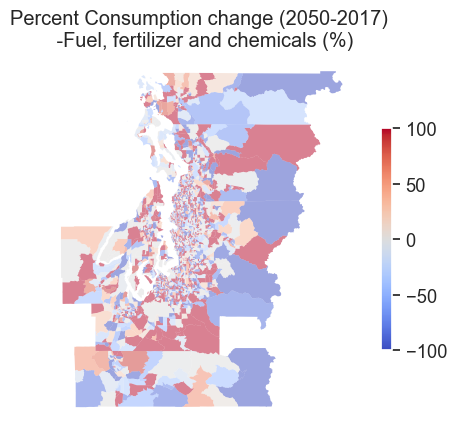

Consumption change (2050-2017) total


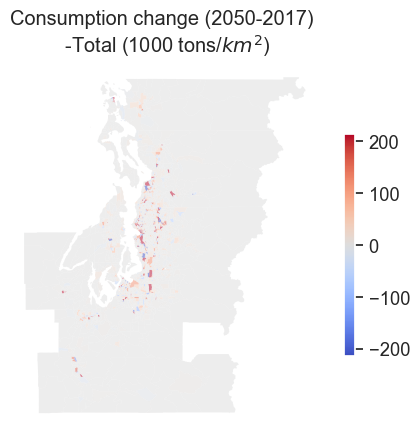

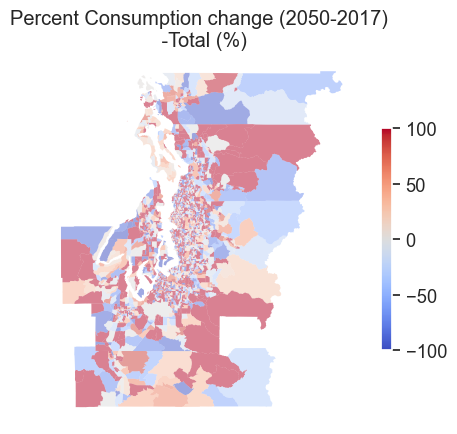

In [39]:

## delta map by sctg

col_groups = synthfirm_output_base['SCTG_Name'].unique().tolist()
col_groups.append('total')

commodity_label['total'] = 'Total'

# upper_bound_lookup = {'bulk': 0.5, 'fuel_fert': 0.3,
#                   'interm_food': 0.1, 'mfr_goods': 0.5,
#                   'total':1}

for plot_pair in plot_pairs.keys():
    output_attr = plot_pair
    left_prefix, right_prefix = plot_pairs[plot_pair]
    
    for attr in col_groups:
        if attr == 'other':
            continue
        # production
        alt_attr = left_prefix + attr + '_per_area'
        base_attr = right_prefix + attr + '_per_area'
        delta_attr = output_attr + '-' +  attr
        print(plot_pair, attr)

        percent_delta_attr = 'Percent ' + output_attr + '-' + attr
        
        commodity_change_comparison.loc[:, delta_attr] = \
        commodity_change_comparison.loc[:, alt_attr] -\
        commodity_change_comparison.loc[:, base_attr]

        commodity_change_comparison.loc[:, percent_delta_attr] = \
        commodity_change_comparison.loc[:, delta_attr] /\
        commodity_change_comparison.loc[:, base_attr] * 100
        
        commodity_change_comparison.fillna(0, inplace = True)
        
        commodity_change_comparison.loc[:, percent_delta_attr].replace(-np.inf, -100, inplace = True)
        commodity_change_comparison.loc[:, percent_delta_attr].replace(np.inf, 100, inplace = True)
        commodity_change_comparison.loc[commodity_change_comparison[percent_delta_attr]>100, percent_delta_attr] = 100
        commodity_change_comparison.loc[commodity_change_comparison[percent_delta_attr]<-100, percent_delta_attr] = -100

        upper_bound = commodity_change_comparison[delta_attr].quantile(0.975)
        lower_bound = commodity_change_comparison[delta_attr].quantile(0.025)
        upper_bound = max(abs(upper_bound), abs(lower_bound)) #symmetric +- range
        # upper_bound = upper_bound_lookup[attr]
        lower_bound = -upper_bound
        
        file_prefix = output_prefix[plot_pair]
        filename = os.path.join(plot_dir, file_prefix + '_' + attr + '_by_zone.png')
        commodity = commodity_label[attr]
        title = f'{plot_pair} \n -{commodity} ({unit})'
        plot_region_map(commodity_change_comparison, delta_attr, title,
                    filename, logscale = False, 
                    vmin=lower_bound, vmax=upper_bound, legend_scale = 0.6, alpha=0.5, cmap='coolwarm')
        # title = f'Percent {plot_pair} \n -{commodity} (%)'
        # filename = os.path.join(plot_dir, 'Percent_' + file_prefix + '_' + attr + '_by_zone.png')
        # plot_region_map(commodity_change_comparison, percent_delta_attr, title,
        #             filename, logscale = False, 
        #             vmin=-100, vmax=100, legend_scale = 0.6, alpha=0.5, cmap='coolwarm')

In [40]:
# generate dataset
production_by_mode_base.drop(columns = ['FAFID', 'CBPZONE', 'GEOID'], inplace = True)  
production_by_mode_2050.drop(columns = ['FAFID', 'CBPZONE', 'GEOID'], inplace = True)  
consumption_by_mode_base.drop(columns = ['FAFID', 'CBPZONE', 'GEOID'], inplace = True)  
consumption_by_mode_2050.drop(columns = ['FAFID', 'CBPZONE', 'GEOID'], inplace = True)  

commodity_change_comparison_mode = \
region_map.merge(production_by_mode_base, 
                 on = ['MESOZONE'], how = 'left')

commodity_change_comparison_mode = \
commodity_change_comparison_mode.merge(production_by_mode_2050,
                                       on = ['MESOZONE'], how = 'left')

commodity_change_comparison_mode = \
commodity_change_comparison_mode.merge(consumption_by_mode_base,
                                     on = ['MESOZONE'], how = 'left')

commodity_change_comparison_mode = \
commodity_change_comparison_mode.merge(consumption_by_mode_2050, 
                                     on = ['MESOZONE'], how = 'left')

commodity_change_comparison_mode.head(5)

GEOID  FAFID      MESOZONE  CBPZONE  \
0  530330293053    531  530330293053    53033   
1  530330205002    531  530330205002    53033   
2  530530620003    531  530530620003    53053   
3  530530613002    531  530530613002    53053   
4  530610527055    531  530610527055    53061   

                                            geometry    area_x  \
0  MULTIPOLYGON (((-122.21292 47.42784, -122.2129...  0.891907   
1  MULTIPOLYGON (((-122.31347 47.75749, -122.3085...  0.435127   
2  MULTIPOLYGON (((-122.42101 47.23054, -122.4164...  0.291051   
3  MULTIPOLYGON (((-122.46102 47.25418, -122.4538...  0.254453   
4  MULTIPOLYGON (((-122.14090 48.04966, -122.1408...  0.595708   

   2017_prod_Air and Parcel_per_area  2017_prod_Truck_per_area  \
0                                0.0                       0.0   
1                                0.0                       0.0   
2                                0.0                       0.0   
3                                0.0                       0.0   
4                                0.0                       0.0   

   2017_prod_Rail and IMX_per_area  2017_prod_total_per_area  ...  \
0                              0.0                       0.0  ...   
1                              0.0                       0.0  ...   
2                              0.0                       0.0  ...   
3                              0.0                       0.0  ...   
4                              0.0                       0.0  ...   

   2050_prod_total_per_area  2017_cons_Air and Parcel_per_area  \
0                       0.0                           0.005082   
1                       0.0                           0.061934   
2                       0.0                           0.000000   
3                       0.0                           0.011723   
4                       0.0                           0.000000   

   2017_cons_Truck_per_area  2017_cons_Rail and IMX_per_area  \
0                  1.550626                         0.008665   
1                  1.542315                         0.004841   
2                  2.413525                         0.077392   
3                 35.553992                         3.634961   
4                  0.000000                         0.000000   

   2017_cons_total_per_area      area  2050_cons_Air and Parcel_per_area  \
0                  1.564373  0.891907                           0.000496   
1                  1.609091  0.435127                           0.047767   
2                  2.490917  0.291051                           0.000000   
3                 39.200677  0.254453                           0.147351   
4                  0.000000  0.595708                           0.000000   

   2050_cons_Truck_per_area  2050_cons_Rail and IMX_per_area  \
0                  3.833873                         0.017330   
1                  1.239885                         0.005879   
2                  0.062882                         0.000000   
3                  5.402115                         0.124535   
4                  0.000000                         0.000000   

   2050_cons_total_per_area  
0                  3.851699  
1                  1.293531  
2                  0.062882  
3                  5.674000  
4                  0.000000  

[5 rows x 24 columns]

Production change (2050-2017) Air and Parcel


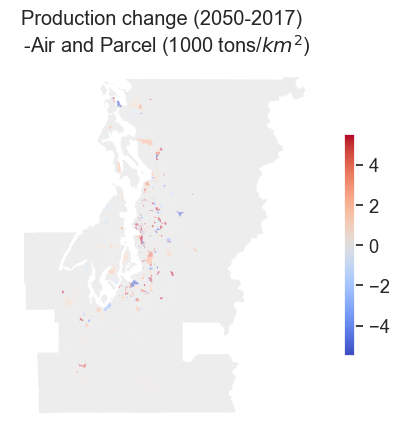

Production change (2050-2017) Truck


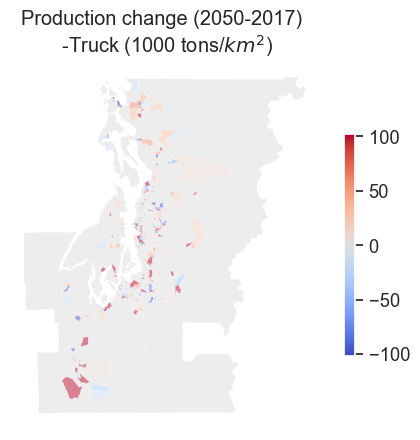

Production change (2050-2017) Rail and IMX


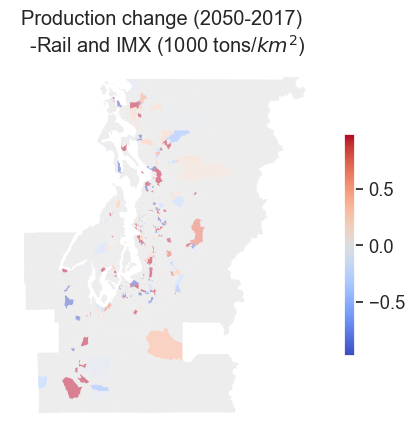

Consumption change (2050-2017) Air and Parcel


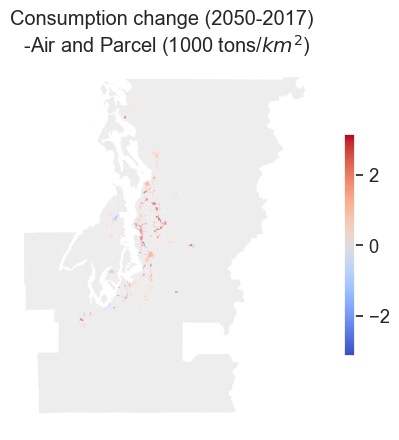

Consumption change (2050-2017) Truck


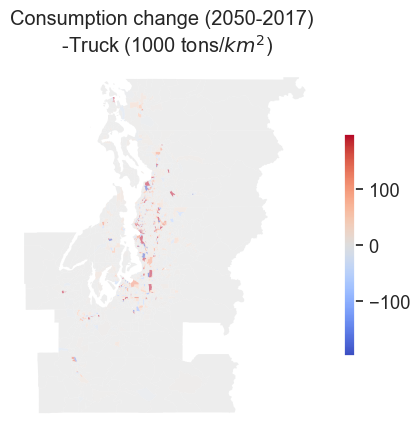

Consumption change (2050-2017) Rail and IMX


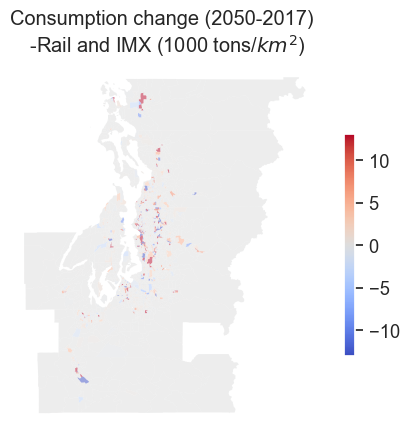

In [42]:
# delta by mode
modes = synthfirm_output_base['Mode'].unique().tolist()
# upper_bound_lookup_mode = {'Truck':0.5, 'Rail and IMX':0.4, 'Air and Parcel':0.005}
for plot_pair in plot_pairs.keys():
    output_attr = plot_pair
    left_prefix, right_prefix = plot_pairs[plot_pair]
    
    for mode in modes:

        # production
        alt_attr = left_prefix + mode + '_per_area'
        base_attr = right_prefix + mode + '_per_area'
        delta_attr = output_attr + '-' +  mode
        print(plot_pair, mode)

        percent_delta_attr = 'Percent ' + output_attr + '-' + mode
        
        commodity_change_comparison_mode.loc[:, delta_attr] = \
        commodity_change_comparison_mode.loc[:, alt_attr] -\
        commodity_change_comparison_mode.loc[:, base_attr]

        commodity_change_comparison_mode.loc[:, percent_delta_attr] = \
        commodity_change_comparison_mode.loc[:, delta_attr] /\
        commodity_change_comparison_mode.loc[:, base_attr] * 100
        
        commodity_change_comparison_mode.fillna(0, inplace = True)
        
        commodity_change_comparison_mode.loc[:, percent_delta_attr].replace(-np.inf, -100, inplace = True)
        commodity_change_comparison_mode.loc[:, percent_delta_attr].replace(np.inf, 100, inplace = True)
        commodity_change_comparison_mode.loc[commodity_change_comparison_mode[percent_delta_attr]>100, percent_delta_attr] = 100
        commodity_change_comparison_mode.loc[commodity_change_comparison_mode[percent_delta_attr]<-100, percent_delta_attr] = -100

        upper_bound = commodity_change_comparison_mode[delta_attr].quantile(0.975)
        lower_bound = commodity_change_comparison_mode[delta_attr].quantile(0.025)
        upper_bound = max(abs(upper_bound), abs(lower_bound)) #symmetric +- range
        # upper_bound = upper_bound_lookup_mode[mode]
        lower_bound = -upper_bound
        
        file_prefix = output_prefix[plot_pair]
        filename = os.path.join(plot_dir, file_prefix + '_' + mode + '_by_zone.png')

        title = f'{plot_pair} \n -{mode} ({unit})'
        plot_region_map(commodity_change_comparison_mode, delta_attr, title,
                    filename, logscale = False, 
                    vmin=lower_bound, vmax=upper_bound, legend_scale = 0.6, alpha=0.5, cmap='coolwarm')
        # title = f'Percent {plot_pair} \n -{mode} (%)'
        # filename = os.path.join(plot_dir, 'Percent_' + file_prefix + '_' + mode + '_by_county.png')
        # plot_county_map(commodity_change_comparison_mode, percent_delta_attr, title,
        #             filename, logscale = False, 
        #             vmin=-100, vmax=100, legend_scale = 0.6, alpha=0.5, cmap='coolwarm')

In [86]:
commodity_change_comparison.to_csv(os.path.join('synthfirm_summary_by_sctg_zone.csv'))


In [22]:
commodity_change_comparison_mode.to_csv(os.path.join('synthfirm_summary_by_mode_zone.csv'))